# Tutorial 3: Building Inputs with the Composable API

The Composable API is the powerhouse of braintools.input, providing an object-oriented approach that allows you to combine, transform, and manipulate current inputs in sophisticated ways.

## Learning Objectives

By the end of this tutorial, you will:
- Master all composable input classes and their parameters
- Combine inputs using arithmetic operations (+, -, *, /)
- Apply transformations (clipping, smoothing, shifting, etc.)
- Build complex experimental protocols with reusable components
- Create sequential and parallel input combinations
- Optimize composable workflows for performance

## Setup

In [36]:
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as scipy_signal

import braintools

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

# Simulation parameters
dt = 0.1 * u.ms
brainstate.environ.set(dt=dt)

In [37]:
def plot_signal(signal, duration, title, ax=None, color='b', alpha=1.0, label=None):
    """Enhanced plotting function with more options."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 4))

    dt_val = u.get_magnitude(dt)
    duration_val = u.get_magnitude(duration)
    time_points = np.arange(0, duration_val, dt_val)
    signal_val = u.get_magnitude(signal)

    if len(time_points) > len(signal_val):
        time_points = time_points[:len(signal_val)]
    elif len(signal_val) > len(time_points):
        signal_val = signal_val[:len(time_points)]

    line = ax.plot(time_points, signal_val, color=color, linewidth=1.5, alpha=alpha, label=label)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Current (nA)')
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    if label is not None:
        ax.legend()

    return ax, line[0]

In [38]:
def plot_multiple_signals(signals, labels, duration, title, colors=None):
    """Plot multiple signals on the same axes."""
    fig, ax = plt.subplots(figsize=(12, 6))

    if colors is None:
        colors = [f'C{i}' for i in range(len(signals))]

    for signal, label, color in zip(signals, labels, colors):
        plot_signal(signal, duration, title, ax, color=color, label=label, alpha=0.8)

    ax.legend()
    return ax

## 1. Basic Composable Inputs

Let's start with the fundamental building blocks of the composable API.

### 1.1 Basic Input Classes

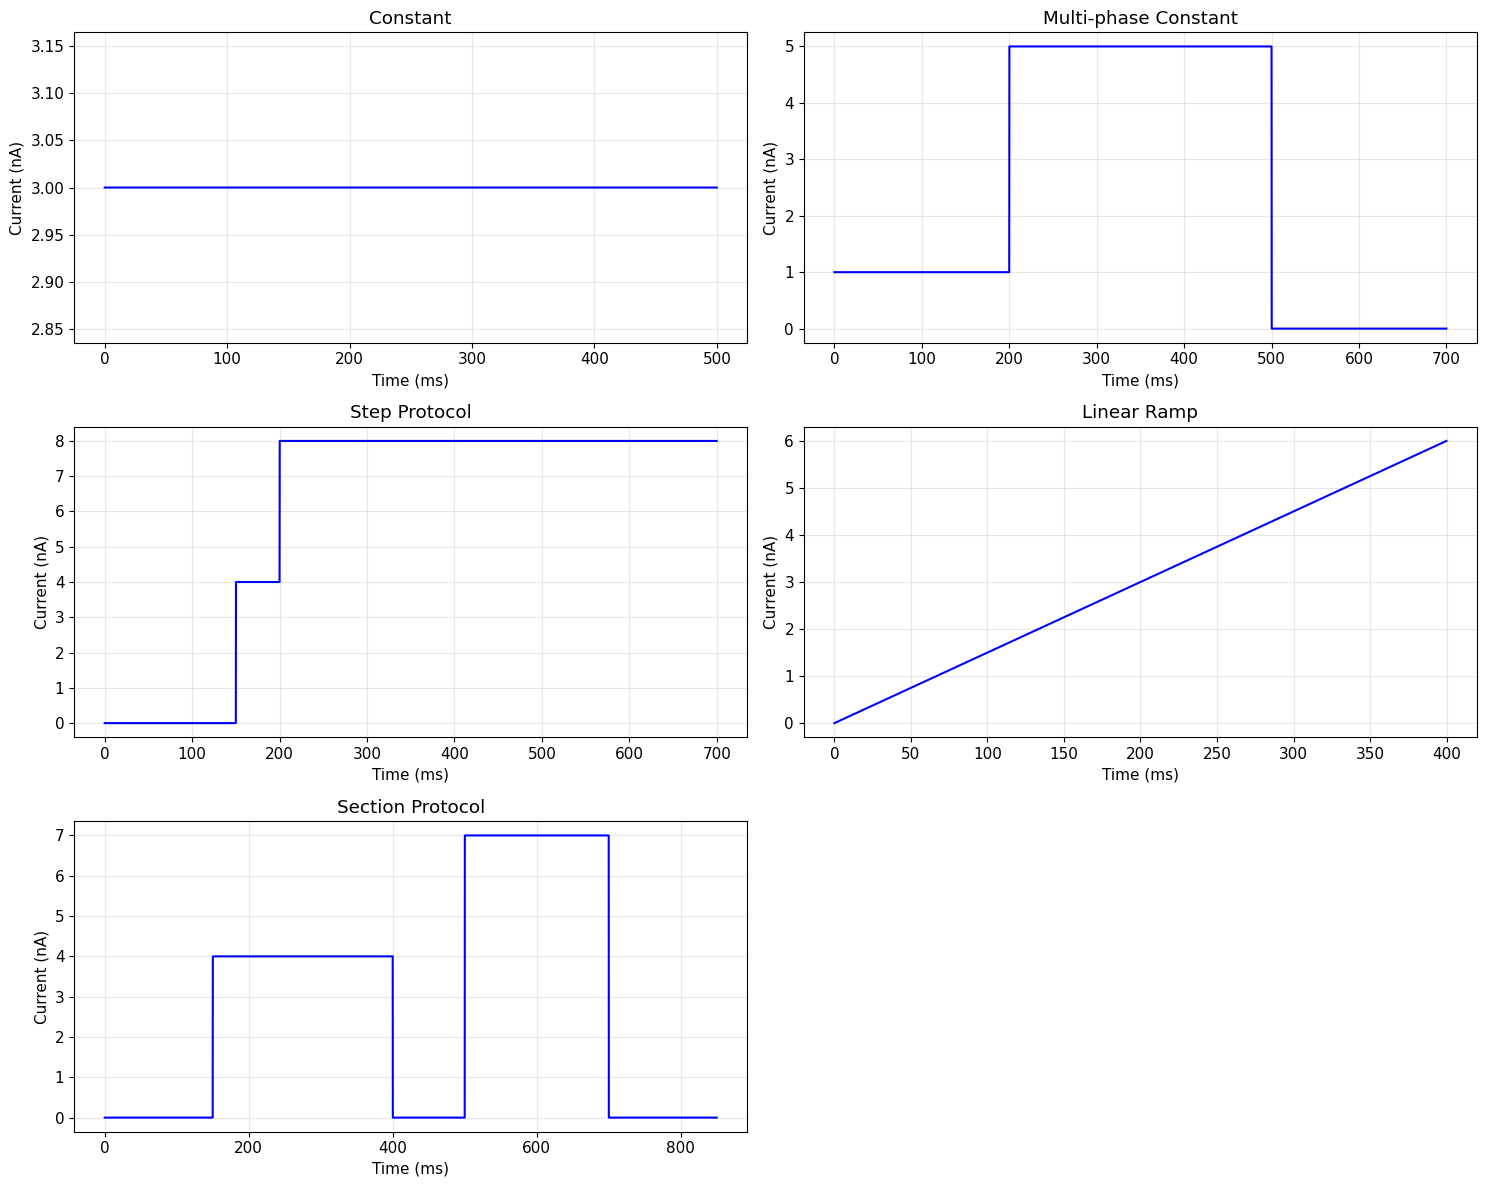

Key differences from functional API:
- Objects are created first, then called to generate arrays
- Objects can be reused, modified, and combined
- More memory overhead but much more flexible


In [39]:
with brainstate.environ.context(dt=dt):
    # Constant inputs - sustained current levels
    const1 = braintools.input.Constant([(3.0, 500 * u.ms)])
    const2 = braintools.input.Constant([(1.0, 200 * u.ms), (5.0, 300 * u.ms), (0.0, 200 * u.ms)])

    # Step inputs - instantaneous level changes  
    step1 = braintools.input.Step([0, 4, 8, 4, 0], [100 * u.ms, 150 * u.ms, 200 * u.ms, 150 * u.ms, 100 * u.ms],
                                  700 * u.ms)

    # Ramp inputs - linear transitions
    ramp1 = braintools.input.Ramp(0, 6, 400 * u.ms)
    ramp2 = braintools.input.Ramp(6, -2, 300 * u.ms)

    # Section inputs - multi-phase protocols
    section1 = braintools.input.Section(
        [0, 4, 0, 7, 0],
        [150 * u.ms, 250 * u.ms, 100 * u.ms, 200 * u.ms, 150 * u.ms]
    )

    # Generate signals
    signals = [const1(), const2(), step1(), ramp1(), section1()]
    durations = [500 * u.ms, 700 * u.ms, 700 * u.ms, 400 * u.ms, 850 * u.ms]
    titles = ['Constant', 'Multi-phase Constant', 'Step Protocol', 'Linear Ramp', 'Section Protocol']

# Plot basic inputs
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (signal, duration, title) in enumerate(zip(signals, durations, titles)):
    if i < 5:
        plot_signal(signal, duration, title, axes[i])

# Hide the last subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("Key differences from functional API:")
print("- Objects are created first, then called to generate arrays")
print("- Objects can be reused, modified, and combined")
print("- More memory overhead but much more flexible")

### 1.2 Waveform Input Classes

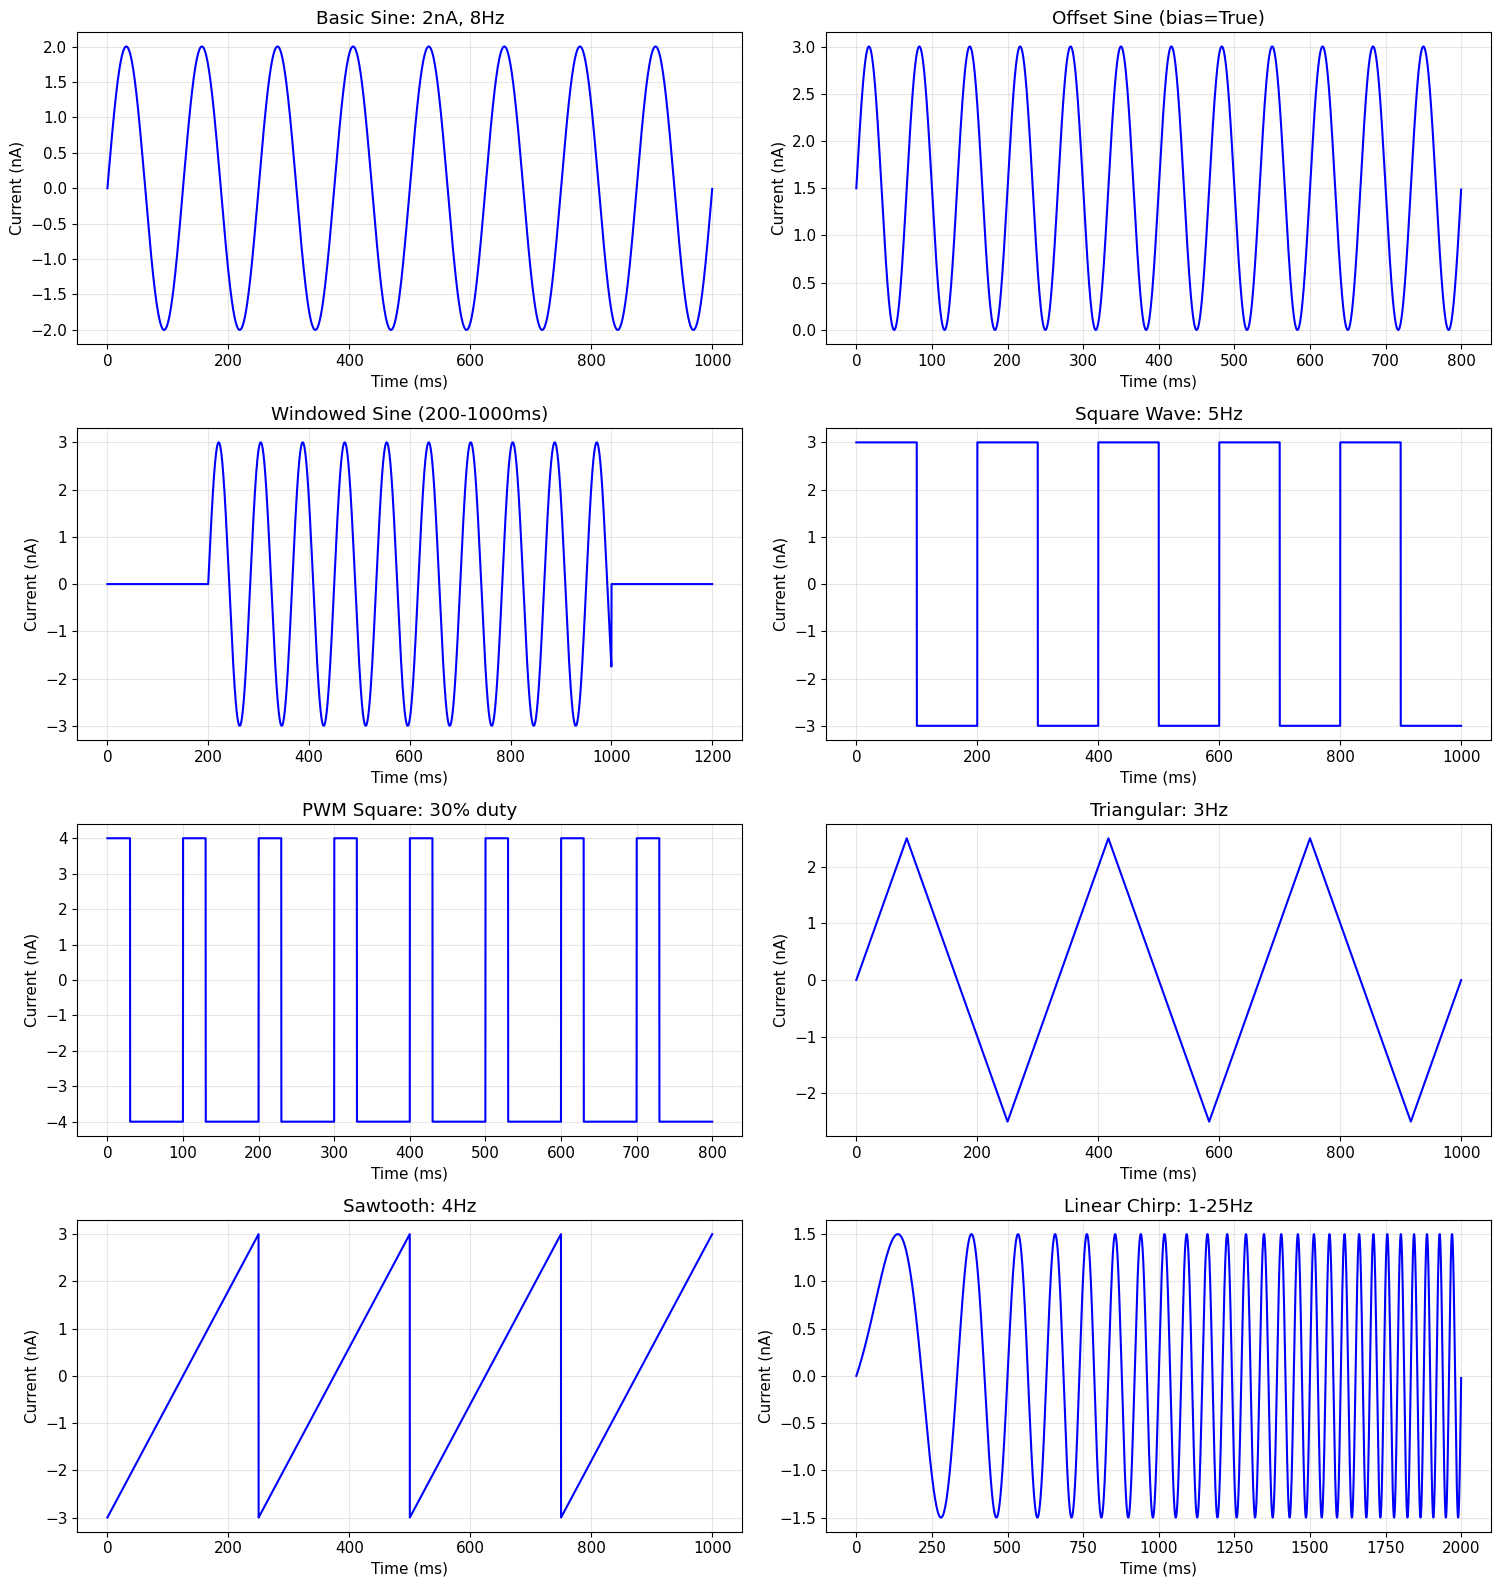

Waveform features:
- bias=True makes signals always positive (adds DC offset)
- t_start/t_end parameters create windowed signals
- duty_cycle controls pulse width in square waves
- method='linear'/'logarithmic' controls chirp frequency progression


In [40]:
with brainstate.environ.context(dt=dt):
    # Sinusoidal inputs
    sine_basic = braintools.input.Sinusoidal(2.0, 8 * u.Hz, 1000 * u.ms)
    sine_offset = braintools.input.Sinusoidal(1.5, 15 * u.Hz, 800 * u.ms, bias=True)  # Always positive
    sine_windowed = braintools.input.Sinusoidal(3.0, 12 * u.Hz, 1200 * u.ms, t_start=200 * u.ms, t_end=1000 * u.ms)

    # Square wave inputs
    square_basic = braintools.input.Square(3.0, 5 * u.Hz, 1000 * u.ms)
    square_pwm = braintools.input.Square(4.0, 10 * u.Hz, 800 * u.ms, duty_cycle=0.3)  # 30% duty cycle

    # Triangular inputs
    tri_basic = braintools.input.Triangular(2.5, 3 * u.Hz, 1000 * u.ms)
    tri_slow = braintools.input.Triangular(4.0, 1 * u.Hz, 2000 * u.ms)  # Slow for I-V curves

    # Sawtooth inputs  
    saw_basic = braintools.input.Sawtooth(3.0, 4 * u.Hz, 1000 * u.ms)
    saw_fast = braintools.input.Sawtooth(2.0, 20 * u.Hz, 500 * u.ms)  # Fast reset

    # Chirp inputs (frequency sweeps)
    chirp_linear = braintools.input.Chirp(1.5, 1 * u.Hz, 25 * u.Hz, 2000 * u.ms, method='linear')
    chirp_log = braintools.input.Chirp(2.0, 0.5 * u.Hz, 50 * u.Hz, 3000 * u.ms, method='logarithmic')

# Generate and plot waveforms
waveforms = [
    (sine_basic(), 1000 * u.ms, 'Basic Sine: 2nA, 8Hz'),
    (sine_offset(), 800 * u.ms, 'Offset Sine (bias=True)'),
    (sine_windowed(), 1200 * u.ms, 'Windowed Sine (200-1000ms)'),
    (square_basic(), 1000 * u.ms, 'Square Wave: 5Hz'),
    (square_pwm(), 800 * u.ms, 'PWM Square: 30% duty'),
    (tri_basic(), 1000 * u.ms, 'Triangular: 3Hz'),
    (saw_basic(), 1000 * u.ms, 'Sawtooth: 4Hz'),
    (chirp_linear()[:20000], 2000 * u.ms, 'Linear Chirp: 1-25Hz')  # Show first 2s
]

fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.flatten()

for i, (signal, duration, title) in enumerate(waveforms):
    plot_signal(signal, duration, title, axes[i])

plt.tight_layout()
plt.show()

print("Waveform features:")
print("- bias=True makes signals always positive (adds DC offset)")
print("- t_start/t_end parameters create windowed signals")
print("- duty_cycle controls pulse width in square waves")
print("- method='linear'/'logarithmic' controls chirp frequency progression")

### 1.3 Pulse Input Classes

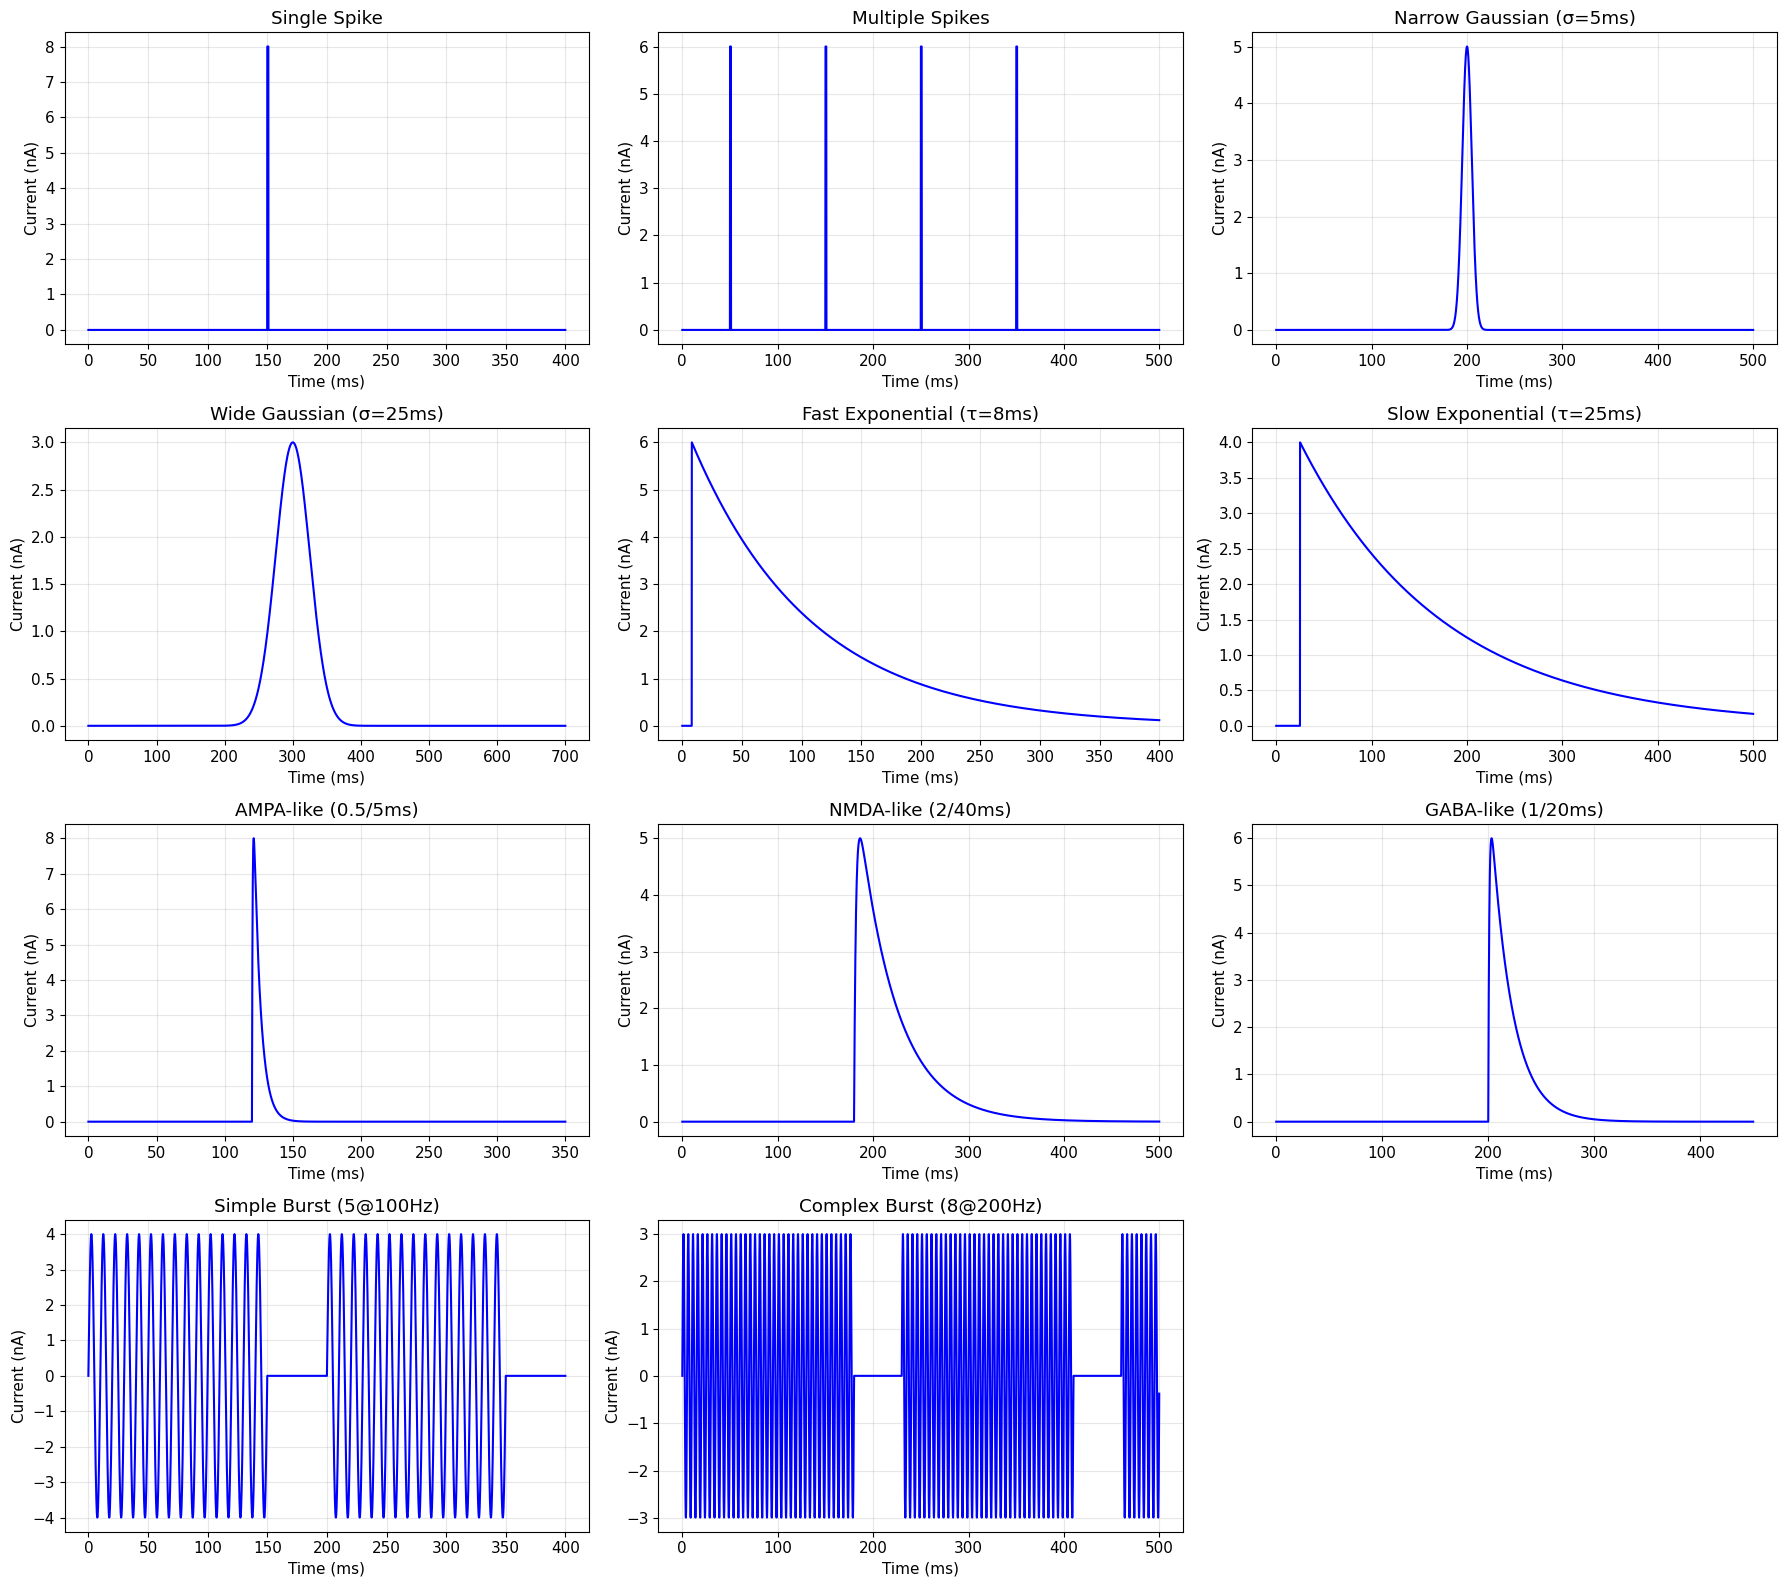

Pulse parameters:
- Spike: sp_times (single or list), duration, sp_lens, sp_sizes
- GaussianPulse: center, duration, sigma, sp_sizes
- ExponentialDecay: onset, duration, tau, sp_sizes
- DoubleExponential: onset, duration, tau_rise, tau_decay, sp_sizes
- Burst: start_time, duration, n_bursts, burst_freq, sp_sizes


In [41]:
with brainstate.environ.context(dt=dt):
    # Spike inputs - delta function-like
    single_spike = braintools.input.Spike([150 * u.ms], 400 * u.ms, sp_lens=1.0 * u.ms, sp_sizes=8.0)
    multi_spikes = braintools.input.Spike([50, 150, 250, 350] * u.ms, 500 * u.ms, sp_lens=1.0 * u.ms, sp_sizes=6.0)

    # Gaussian pulses - smooth, bell-shaped
    gaussian_narrow = braintools.input.GaussianPulse(5.0, 200 * u.ms, sigma=5 * u.ms, duration=500 * u.ms, )
    gaussian_wide = braintools.input.GaussianPulse(3.0, 300 * u.ms, sigma=25 * u.ms, duration=700 * u.ms, )

    # Exponential decay - EPSC/IPSC-like
    exp_fast = braintools.input.ExponentialDecay(6.0, 100 * u.ms, duration=400 * u.ms, t_start=8 * u.ms)
    exp_slow = braintools.input.ExponentialDecay(4.0, 150 * u.ms, duration=500 * u.ms, t_start=25 * u.ms)

    # Double exponential - realistic synaptic currents
    ampa_like = braintools.input.DoubleExponential(8.0, t_start=120 * u.ms, duration=350 * u.ms, tau_rise=0.5 * u.ms,
                                                   tau_decay=5 * u.ms)
    nmda_like = braintools.input.DoubleExponential(5.0, t_start=180 * u.ms, duration=500 * u.ms, tau_rise=2 * u.ms,
                                                   tau_decay=40 * u.ms)
    gaba_like = braintools.input.DoubleExponential(6.0, t_start=200 * u.ms, duration=450 * u.ms, tau_rise=1 * u.ms,
                                                   tau_decay=20 * u.ms)

    # Burst patterns
    burst_simple = braintools.input.Burst(burst_duration=150 * u.ms, duration=400 * u.ms, n_bursts=5,
                                          burst_freq=100 * u.Hz, burst_amp=4.0, inter_burst_interval=50 * u.ms)
    burst_complex = braintools.input.Burst(burst_duration=180 * u.ms, duration=500 * u.ms, n_bursts=8,
                                           burst_freq=200 * u.Hz, burst_amp=3.0, inter_burst_interval=50 * u.ms)

# Generate and plot pulses
pulses = [
    (single_spike(), 400 * u.ms, 'Single Spike'),
    (multi_spikes(), 500 * u.ms, 'Multiple Spikes'),
    (gaussian_narrow(), 500 * u.ms, 'Narrow Gaussian (σ=5ms)'),
    (gaussian_wide(), 700 * u.ms, 'Wide Gaussian (σ=25ms)'),
    (exp_fast(), 400 * u.ms, 'Fast Exponential (τ=8ms)'),
    (exp_slow(), 500 * u.ms, 'Slow Exponential (τ=25ms)'),
    (ampa_like(), 350 * u.ms, 'AMPA-like (0.5/5ms)'),
    (nmda_like(), 500 * u.ms, 'NMDA-like (2/40ms)'),
    (gaba_like(), 450 * u.ms, 'GABA-like (1/20ms)'),
    (burst_simple(), 400 * u.ms, 'Simple Burst (5@100Hz)'),
    (burst_complex(), 500 * u.ms, 'Complex Burst (8@200Hz)')
]

# Plot in a grid
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for i, (signal, duration, title) in enumerate(pulses):
    if i < len(axes) - 1:  # Leave space for one empty subplot
        plot_signal(signal, duration, title, axes[i])

# Hide the last subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

print("Pulse parameters:")
print("- Spike: sp_times (single or list), duration, sp_lens, sp_sizes")
print("- GaussianPulse: center, duration, sigma, sp_sizes")
print("- ExponentialDecay: onset, duration, tau, sp_sizes")
print("- DoubleExponential: onset, duration, tau_rise, tau_decay, sp_sizes")
print("- Burst: start_time, duration, n_bursts, burst_freq, sp_sizes")

### 1.4 Stochastic Input Classes

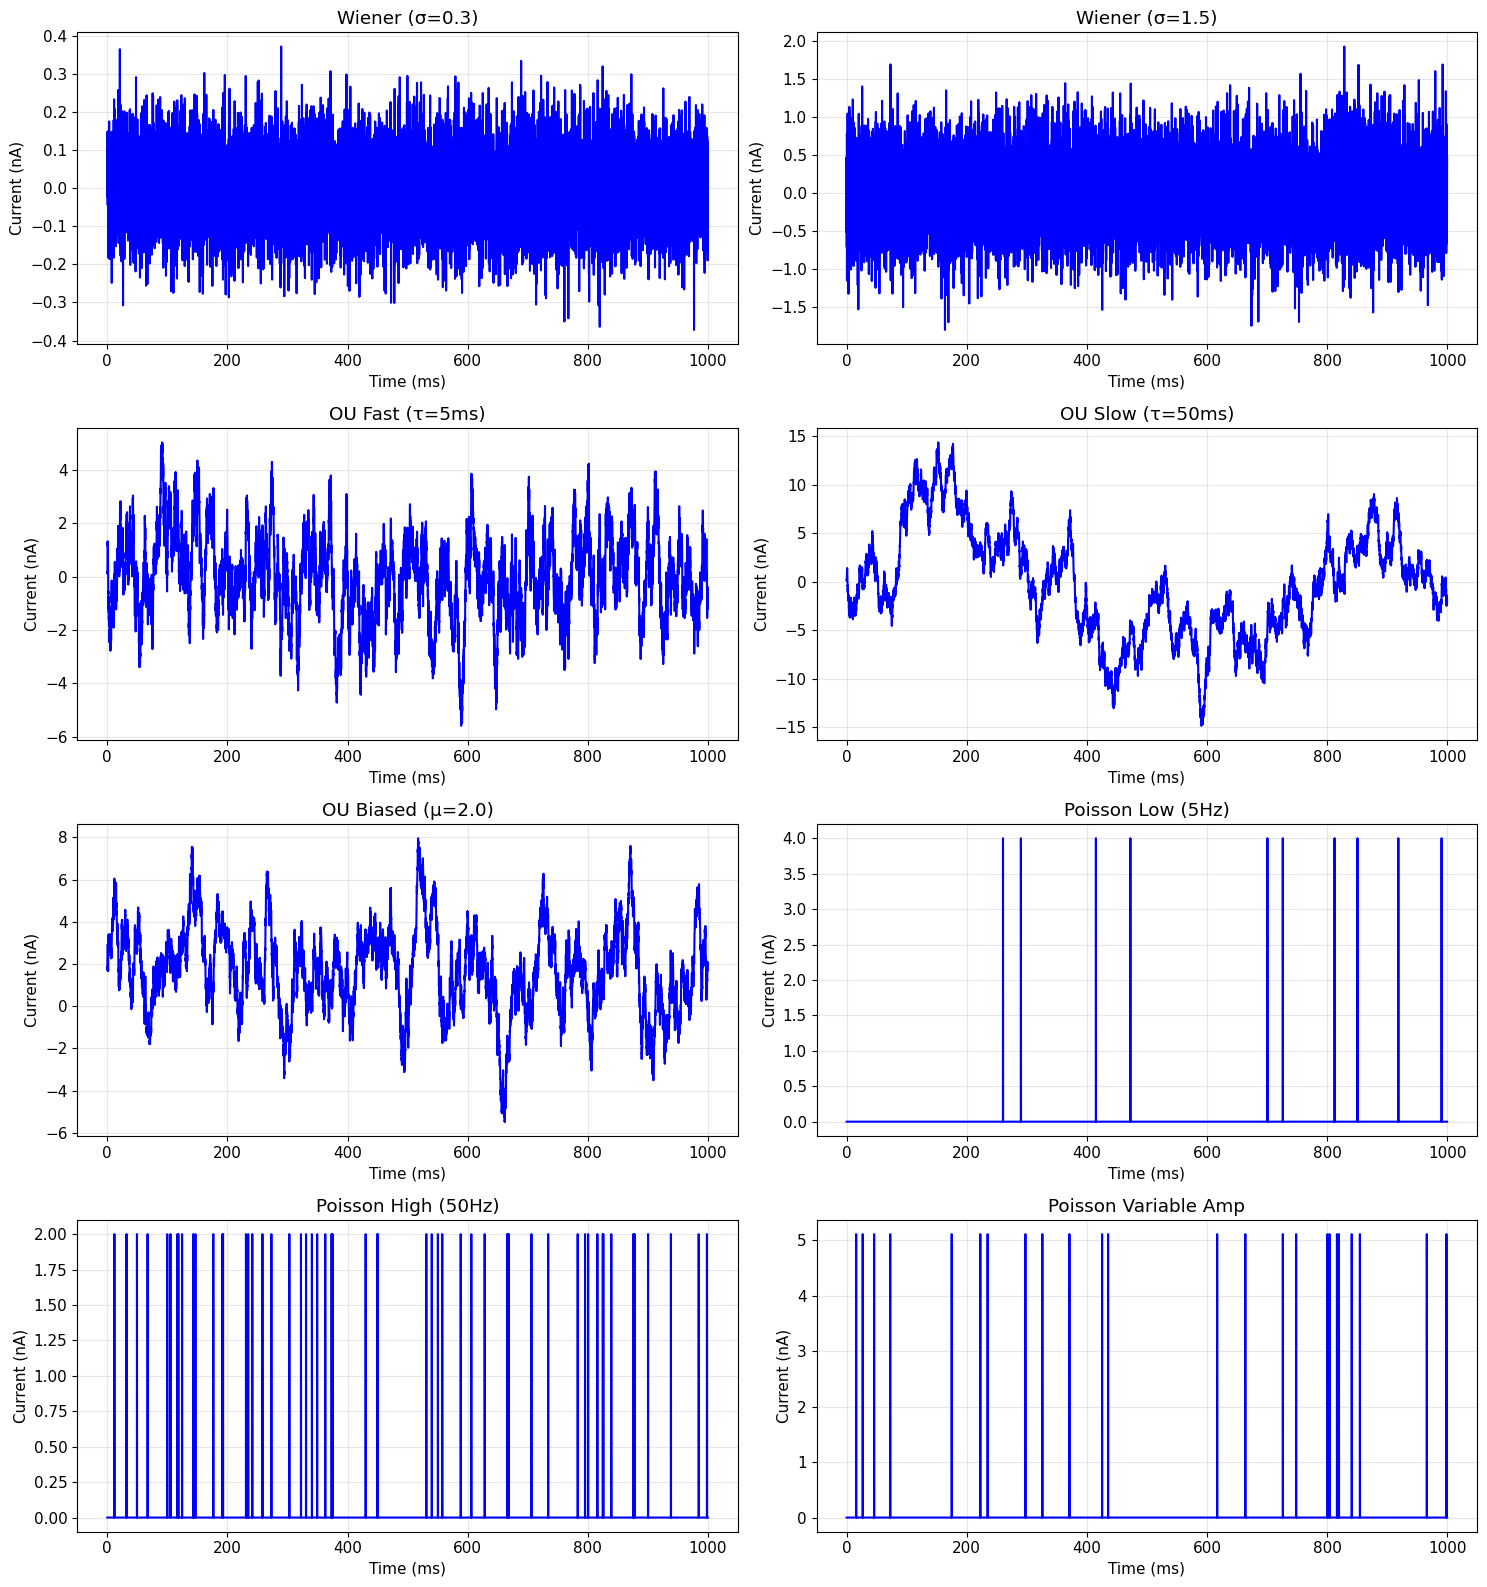

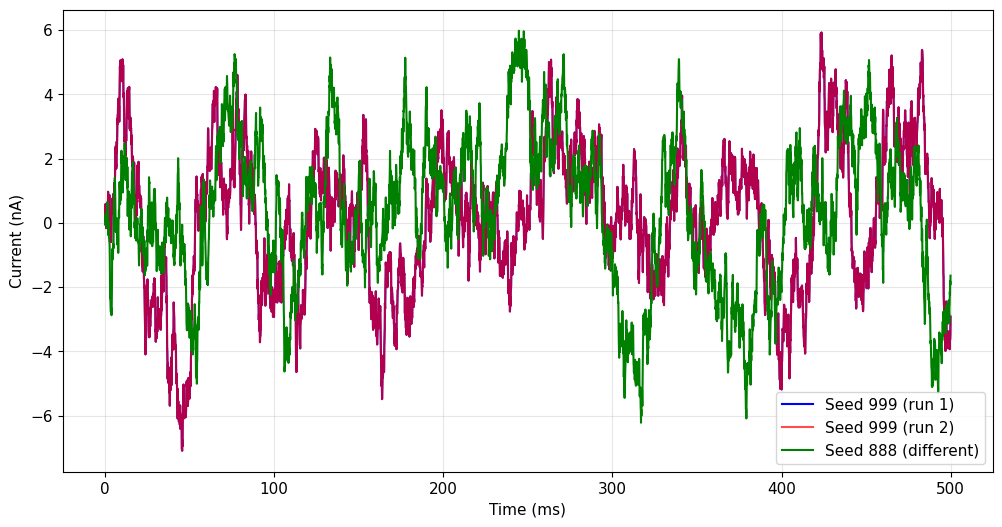

Stochastic features:
- seed parameter ensures reproducibility
- WienerProcess: pure white noise (no correlation)
- OUProcess: colored noise with correlation time tau
- Poisson: spike trains with exponential ISI distribution


In [42]:
with brainstate.environ.context(dt=dt):
    # Wiener processes (Brownian motion)
    wiener_small = braintools.input.WienerProcess(sigma=0.3, duration=1000 * u.ms, seed=42)
    wiener_large = braintools.input.WienerProcess(sigma=1.5, duration=1000 * u.ms, seed=123)

    # Ornstein-Uhlenbeck processes (correlated noise)
    ou_fast = braintools.input.OUProcess(mean=0.0, sigma=1.0, tau=5 * u.ms, duration=1000 * u.ms, seed=42)
    ou_slow = braintools.input.OUProcess(mean=0.0, sigma=1.0, tau=50 * u.ms, duration=1000 * u.ms, seed=42)
    ou_biased = braintools.input.OUProcess(mean=2.0, sigma=0.8, tau=20 * u.ms, duration=1000 * u.ms, seed=456)

    # Poisson spike trains
    poisson_low = braintools.input.Poisson(rate=5 * u.Hz, duration=1000 * u.ms, amplitude=4.0, seed=42)
    poisson_high = braintools.input.Poisson(rate=50 * u.Hz, duration=1000 * u.ms, amplitude=2.0, seed=123)
    poisson_variable = braintools.input.Poisson(
        rate=25 * u.Hz,
        duration=1000 * u.ms,
        amplitude=np.random.uniform(2, 6),  # Variable amplitudes
        seed=789
    )

# Generate signals
stochastic_signals = [
    (wiener_small(), 'Wiener (σ=0.3)'),
    (wiener_large(), 'Wiener (σ=1.5)'),
    (ou_fast(), 'OU Fast (τ=5ms)'),
    (ou_slow(), 'OU Slow (τ=50ms)'),
    (ou_biased(), 'OU Biased (μ=2.0)'),
    (poisson_low(), 'Poisson Low (5Hz)'),
    (poisson_high(), 'Poisson High (50Hz)'),
    (poisson_variable(), 'Poisson Variable Amp')
]

# Plot stochastic processes
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
axes = axes.flatten()

for i, (signal, title) in enumerate(stochastic_signals):
    plot_signal(signal, 1000 * u.ms, title, axes[i])

plt.tight_layout()
plt.show()

# Demonstrate reproducibility with seeds
with brainstate.environ.context(dt=dt):
    # Same seed = same signal
    ou1 = braintools.input.OUProcess(mean=0., sigma=1.0, tau=10 * u.ms, duration=500 * u.ms, seed=999)
    ou2 = braintools.input.OUProcess(mean=0., sigma=1.0, tau=10 * u.ms, duration=500 * u.ms, seed=999)

    # Different seed = different signal
    ou3 = braintools.input.OUProcess(mean=0., sigma=1.0, tau=10 * u.ms, duration=500 * u.ms, seed=888)

fig, ax = plt.subplots(figsize=(12, 6))
plot_signal(ou1(), 500 * u.ms, 'Seed Reproducibility Test', ax, color='b', label='Seed 999 (run 1)')
plot_signal(ou2(), 500 * u.ms, '', ax, color='r', alpha=0.7, label='Seed 999 (run 2)')
plot_signal(ou3(), 500 * u.ms, '', ax, color='g', label='Seed 888 (different)')
ax.legend()
plt.show()

print("Stochastic features:")
print("- seed parameter ensures reproducibility")
print("- WienerProcess: pure white noise (no correlation)")
print("- OUProcess: colored noise with correlation time tau")
print("- Poisson: spike trains with exponential ISI distribution")

## 2. Input Composition - The Power of the Composable API

This is where the composable API really shines - combining inputs using arithmetic operations.

### 2.1 Addition - Signal Superposition

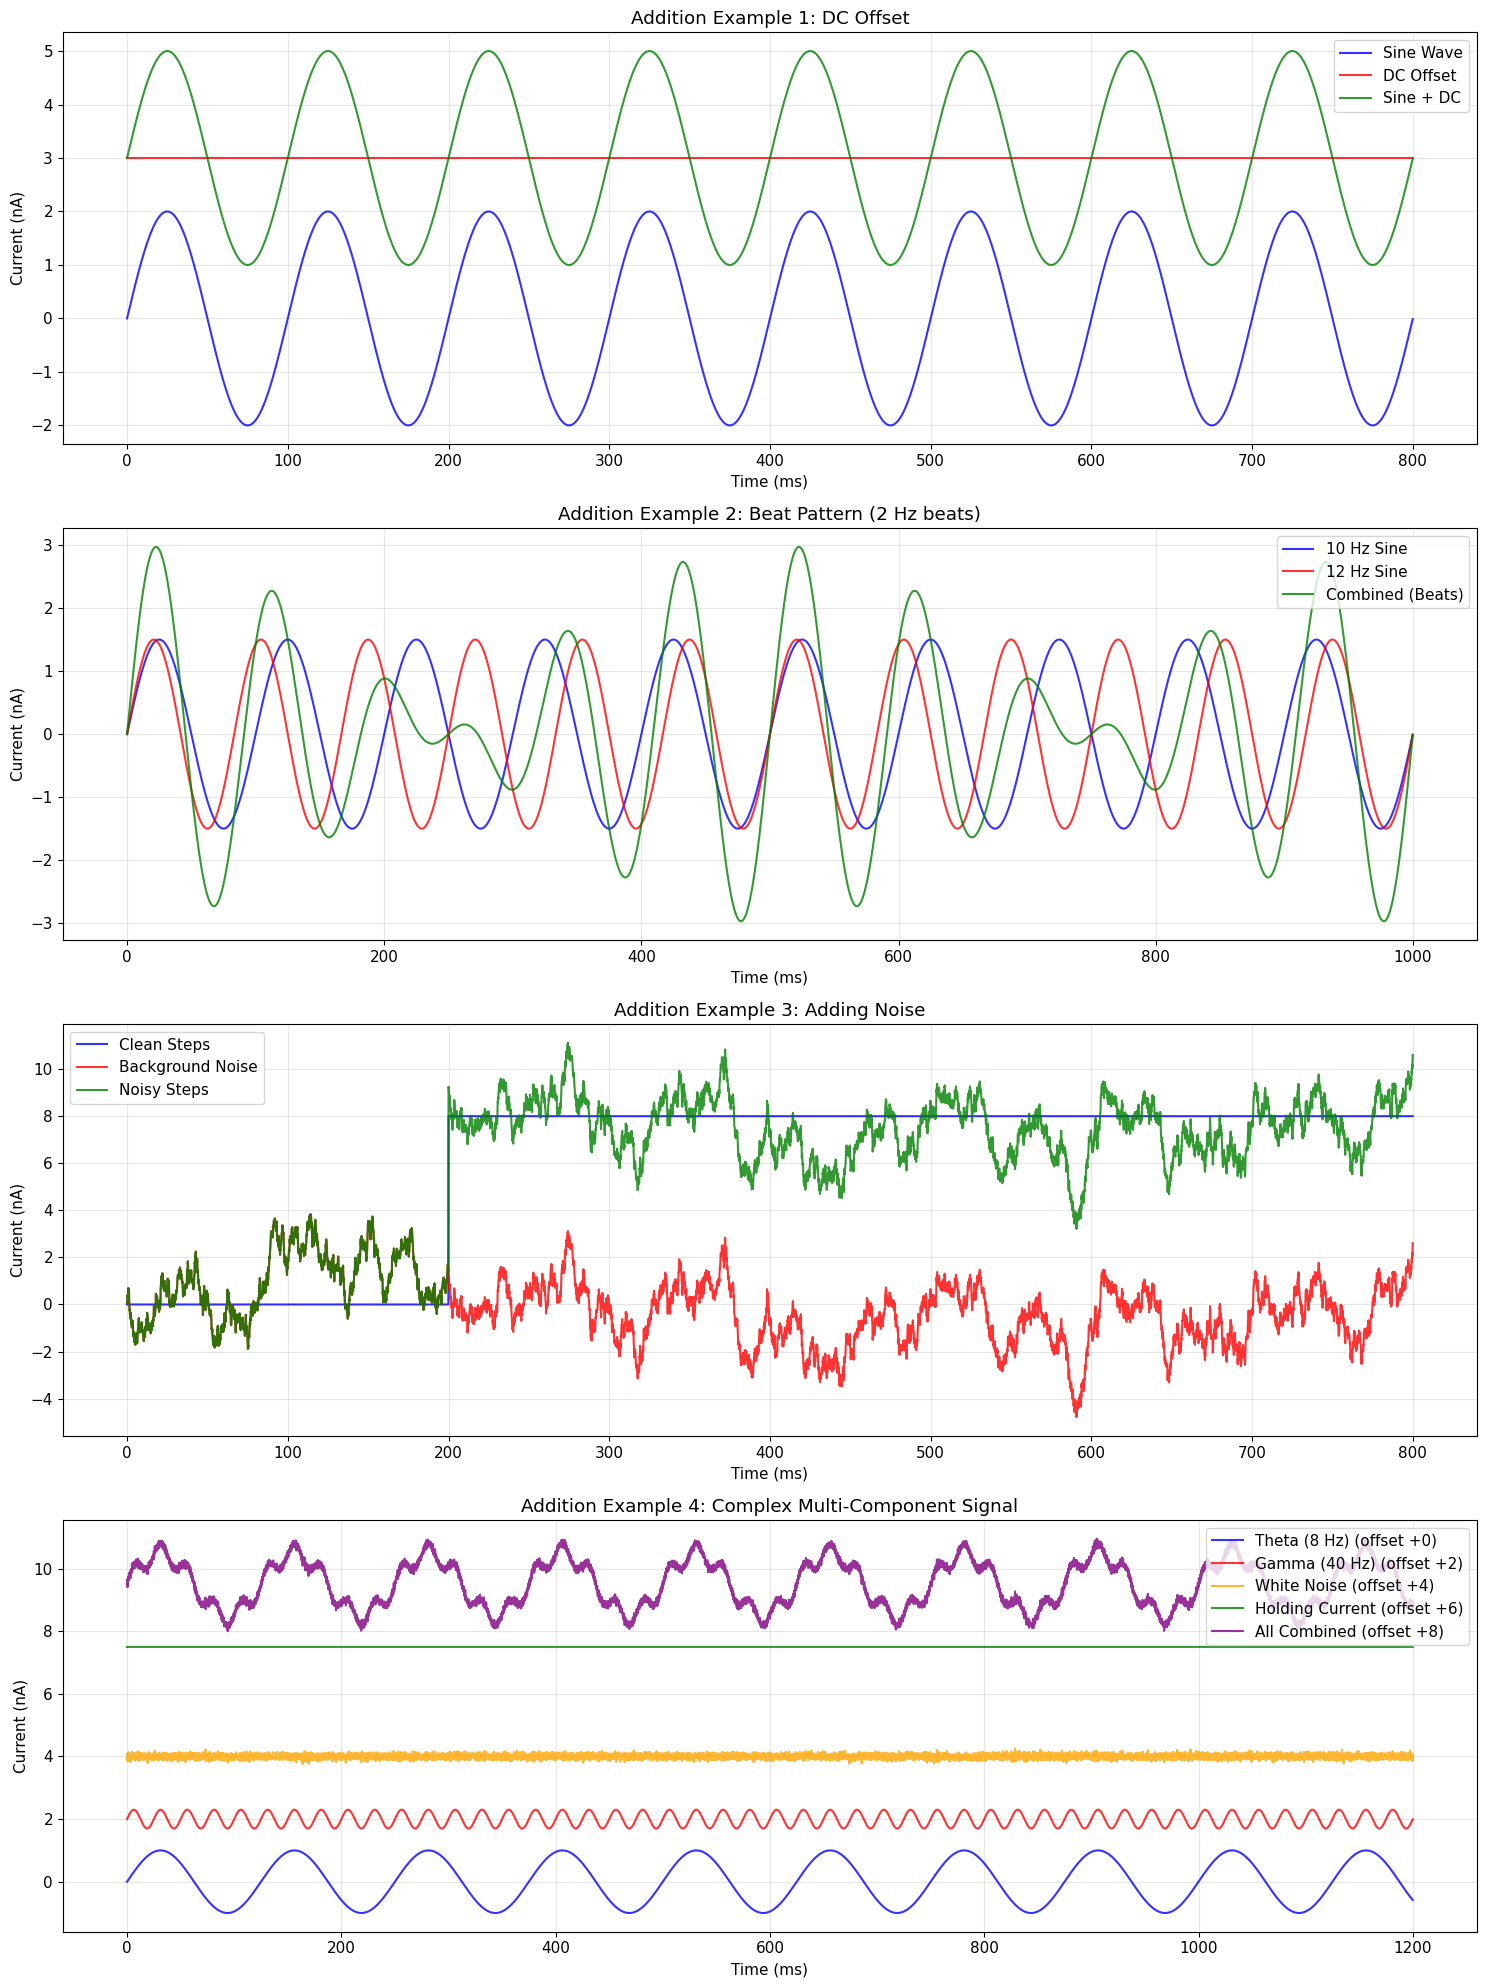

Addition features:
- Linear superposition: output = input1 + input2
- Can combine any number of inputs: a + b + c + d + ...
- Preserves units (nA + nA = nA)
- Order doesn't matter: a + b = b + a


In [43]:
with brainstate.environ.context(dt=dt):
    # Example 1: Adding a constant offset to a sine wave
    sine_base = braintools.input.Sinusoidal(2.0, 10 * u.Hz, 800 * u.ms)
    dc_offset = braintools.input.Constant([(3.0, 800 * u.ms)])
    sine_with_offset = sine_base + dc_offset

    # Example 2: Combining two different frequencies (beat pattern)
    sine_10hz = braintools.input.Sinusoidal(1.5, 10 * u.Hz, 1000 * u.ms)
    sine_12hz = braintools.input.Sinusoidal(1.5, 12 * u.Hz, 1000 * u.ms)
    beats = sine_10hz + sine_12hz  # 2 Hz beat frequency

    # Example 3: Adding noise to a step protocol
    step_protocol = braintools.input.Step([0, 5, 0, 8, 0], [150, 200, 100, 200, 150] * u.ms, 800 * u.ms)
    background_noise = braintools.input.OUProcess(mean=0., sigma=0.5, tau=15 * u.ms, duration=800 * u.ms, seed=42)
    noisy_steps = step_protocol + background_noise

    # Example 4: Complex multi-component signal
    theta = braintools.input.Sinusoidal(1.0, 8 * u.Hz, 1200 * u.ms)  # Theta rhythm
    gamma = braintools.input.Sinusoidal(0.3, 40 * u.Hz, 1200 * u.ms)  # Gamma oscillation
    noise = braintools.input.WienerProcess(sigma=0.2, duration=1200 * u.ms, seed=123)
    holding = braintools.input.Constant([(1.5, 1200 * u.ms)])  # Holding current
    complex_signal = theta + gamma + noise + holding

    # Generate signals
    signals_individual = [
        (sine_base(), 'Sine Wave'),
        (dc_offset(), 'DC Offset'),
        (sine_with_offset(), 'Sine + DC')
    ]

    signals_beats = [
        (sine_10hz(), '10 Hz Sine'),
        (sine_12hz(), '12 Hz Sine'),
        (beats(), 'Combined (Beats)')
    ]

    signals_noisy = [
        (step_protocol(), 'Clean Steps'),
        (background_noise(), 'Background Noise'),
        (noisy_steps(), 'Noisy Steps')
    ]

    signals_complex = [
        (theta(), 'Theta (8 Hz)'),
        (gamma(), 'Gamma (40 Hz)'),
        (noise(), 'White Noise'),
        (holding(), 'Holding Current'),
        (complex_signal(), 'All Combined')
    ]

# Plot addition examples
fig, axes = plt.subplots(4, 1, figsize=(15, 20))

colors = ['blue', 'red', 'green']

# DC offset example
ax = axes[0]
for i, (signal, label) in enumerate(signals_individual):
    plot_signal(signal, 800 * u.ms, 'Addition Example 1: DC Offset', ax,
                color=colors[i],
                label=label, alpha=0.8)
ax.legend()

# Beat pattern example
ax = axes[1]
for i, (signal, label) in enumerate(signals_beats):
    plot_signal(signal, 1000 * u.ms, 'Addition Example 2: Beat Pattern (2 Hz beats)', ax,
                color=colors[i],
                label=label, alpha=0.8)
ax.legend()

# Noisy steps example
ax = axes[2]
for i, (signal, label) in enumerate(signals_noisy):
    plot_signal(signal, 800 * u.ms, 'Addition Example 3: Adding Noise', ax,
                color=colors[i],
                label=label, alpha=0.8)
ax.legend()

# Complex signal example - show only final result and components separately
ax = axes[3]
# Plot components with offsets for clarity
offsets = [0, 2, 4, 6, 8]
colors = ['blue', 'red', 'orange', 'green', 'purple']
for i, (signal, label) in enumerate(signals_complex):
    offset_signal = signal + offsets[i]
    plot_signal(offset_signal, 1200 * u.ms, 'Addition Example 4: Complex Multi-Component Signal', ax,
                color=colors[i], label=f'{label} (offset +{offsets[i]})', alpha=0.8)
ax.legend()

plt.tight_layout()
plt.show()

print("Addition features:")
print("- Linear superposition: output = input1 + input2")
print("- Can combine any number of inputs: a + b + c + d + ...")
print("- Preserves units (nA + nA = nA)")
print("- Order doesn't matter: a + b = b + a")

### 2.2 Multiplication - Amplitude Modulation

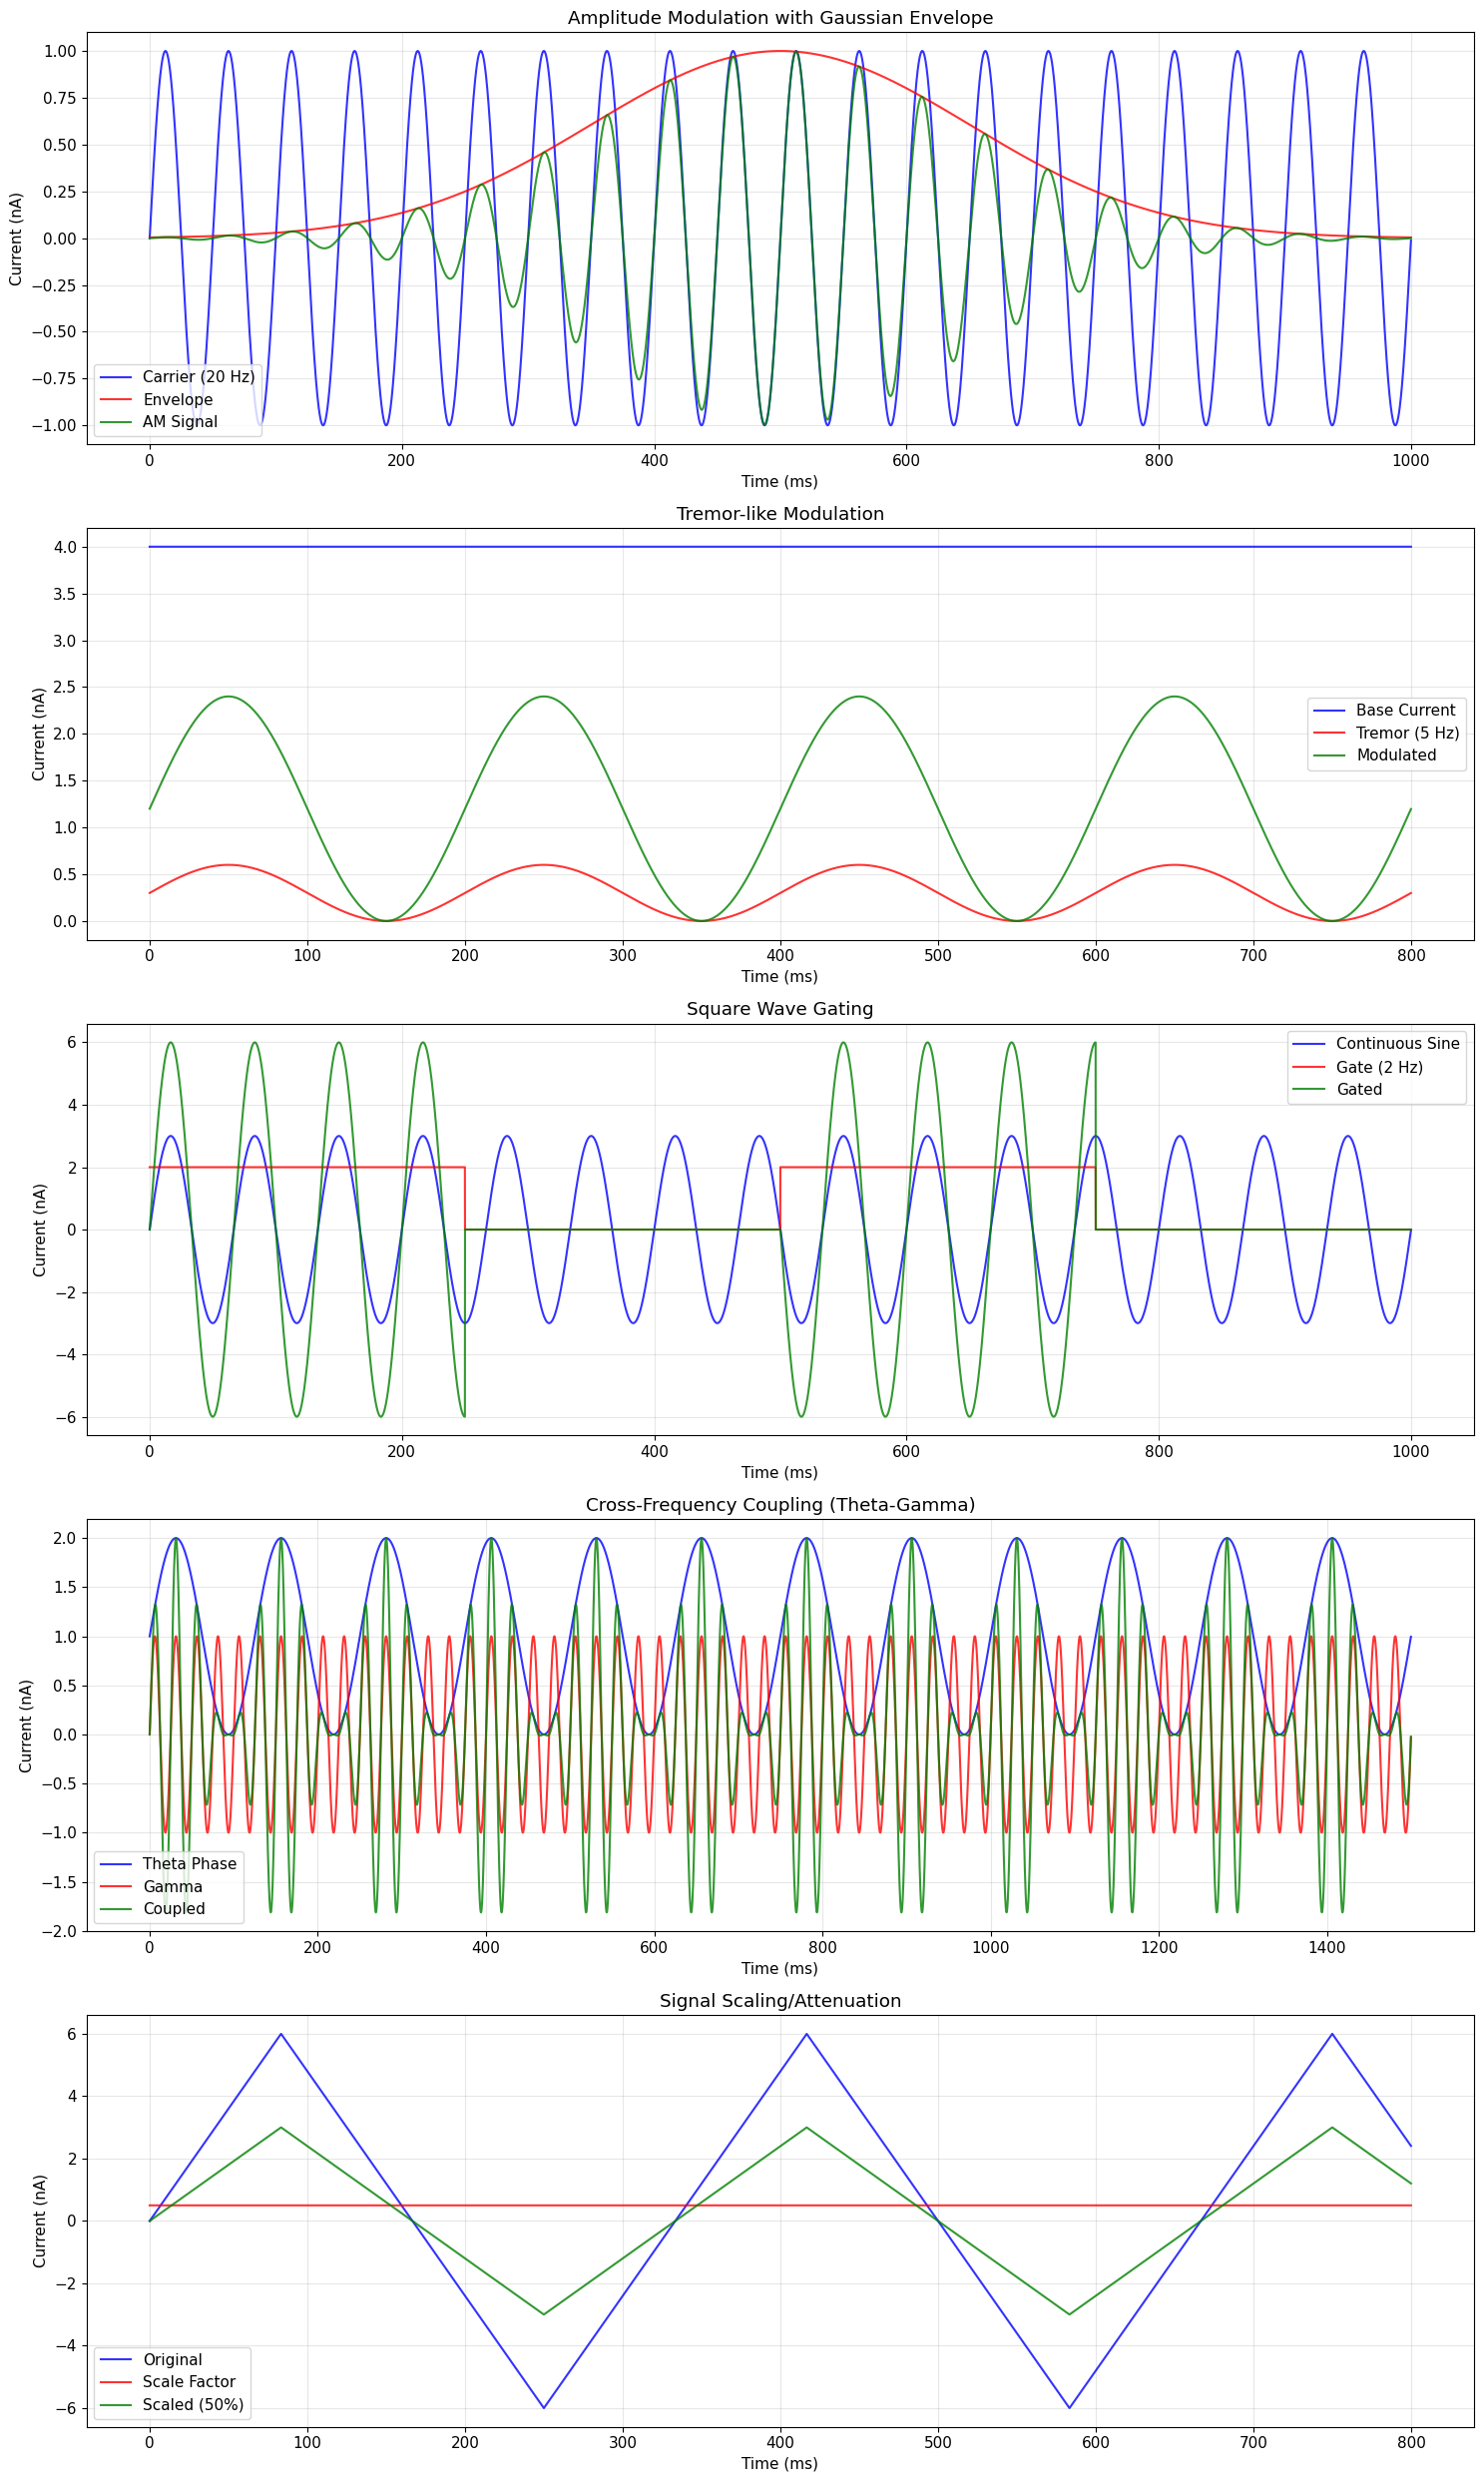

Multiplication features:
- Element-wise multiplication: output[t] = input1[t] * input2[t]
- Use bias=True for positive modulation signals
- Great for amplitude modulation, gating, and scaling
- Units: nA * dimensionless = nA


In [44]:
with brainstate.environ.context(dt=dt):
    # Example 1: Amplitude modulation with envelope
    carrier = braintools.input.Sinusoidal(1.0, 20 * u.Hz, 1000 * u.ms)
    envelope = braintools.input.GaussianPulse(1.0, 500 * u.ms, 150 * u.ms, 1000 * u.ms)
    am_signal = carrier * envelope

    # Example 2: Tremor-like modulation
    base_current = braintools.input.Constant([(4.0, 800 * u.ms)])
    tremor = braintools.input.Sinusoidal(0.3, 5 * u.Hz, 800 * u.ms, bias=True)  # Positive modulation
    tremor_current = base_current * tremor

    # Example 3: Gating with square wave
    continuous_sine = braintools.input.Sinusoidal(3.0, 15 * u.Hz, 1000 * u.ms)
    gate = braintools.input.Square(1.0, 2 * u.Hz, 1000 * u.ms, bias=True)  # Positive square wave
    gated_sine = continuous_sine * gate

    # Example 4: Cross-frequency coupling (phase-amplitude coupling)
    theta_phase = braintools.input.Sinusoidal(1.0, 8 * u.Hz, 1500 * u.ms, bias=True)  # Theta phase
    gamma_burst = braintools.input.Sinusoidal(1.0, 40 * u.Hz, 1500 * u.ms)  # Gamma oscillation
    coupled_signal = gamma_burst * theta_phase

    # Example 5: Scaling/attenuation
    original = braintools.input.Triangular(6.0, 3 * u.Hz, 800 * u.ms)
    scalar = braintools.input.Constant([(0.5, 800 * u.ms)])  # 50% scaling factor
    scaled = original * scalar

# Generate signals for multiplication examples
mult_examples = [
    {
        'signals': [(carrier(), 'Carrier (20 Hz)'), (envelope(), 'Envelope'), (am_signal(), 'AM Signal')],
        'duration': 1000 * u.ms,
        'title': 'Amplitude Modulation with Gaussian Envelope'
    },
    {
        'signals': [(base_current(), 'Base Current'), (tremor(), 'Tremor (5 Hz)'), (tremor_current(), 'Modulated')],
        'duration': 800 * u.ms,
        'title': 'Tremor-like Modulation'
    },
    {
        'signals': [(continuous_sine(), 'Continuous Sine'), (gate(), 'Gate (2 Hz)'), (gated_sine(), 'Gated')],
        'duration': 1000 * u.ms,
        'title': 'Square Wave Gating'
    },
    {
        'signals': [(theta_phase(), 'Theta Phase'), (gamma_burst(), 'Gamma'), (coupled_signal(), 'Coupled')],
        'duration': 1500 * u.ms,
        'title': 'Cross-Frequency Coupling (Theta-Gamma)'
    },
    {
        'signals': [(original(), 'Original'), (scalar(), 'Scale Factor'), (scaled(), 'Scaled (50%)')],
        'duration': 800 * u.ms,
        'title': 'Signal Scaling/Attenuation'
    }
]

# Plot multiplication examples
fig, axes = plt.subplots(5, 1, figsize=(15, 25))

colors = ['blue', 'red', 'green']
for i, example in enumerate(mult_examples):
    ax = axes[i]
    for j, (signal, label) in enumerate(example['signals']):
        plot_signal(signal, example['duration'], example['title'], ax,
                    color=colors[j], label=label, alpha=0.8)
    ax.legend()

plt.tight_layout()
plt.show()

print("Multiplication features:")
print("- Element-wise multiplication: output[t] = input1[t] * input2[t]")
print("- Use bias=True for positive modulation signals")
print("- Great for amplitude modulation, gating, and scaling")
print("- Units: nA * dimensionless = nA")

### 2.3 Subtraction and Division

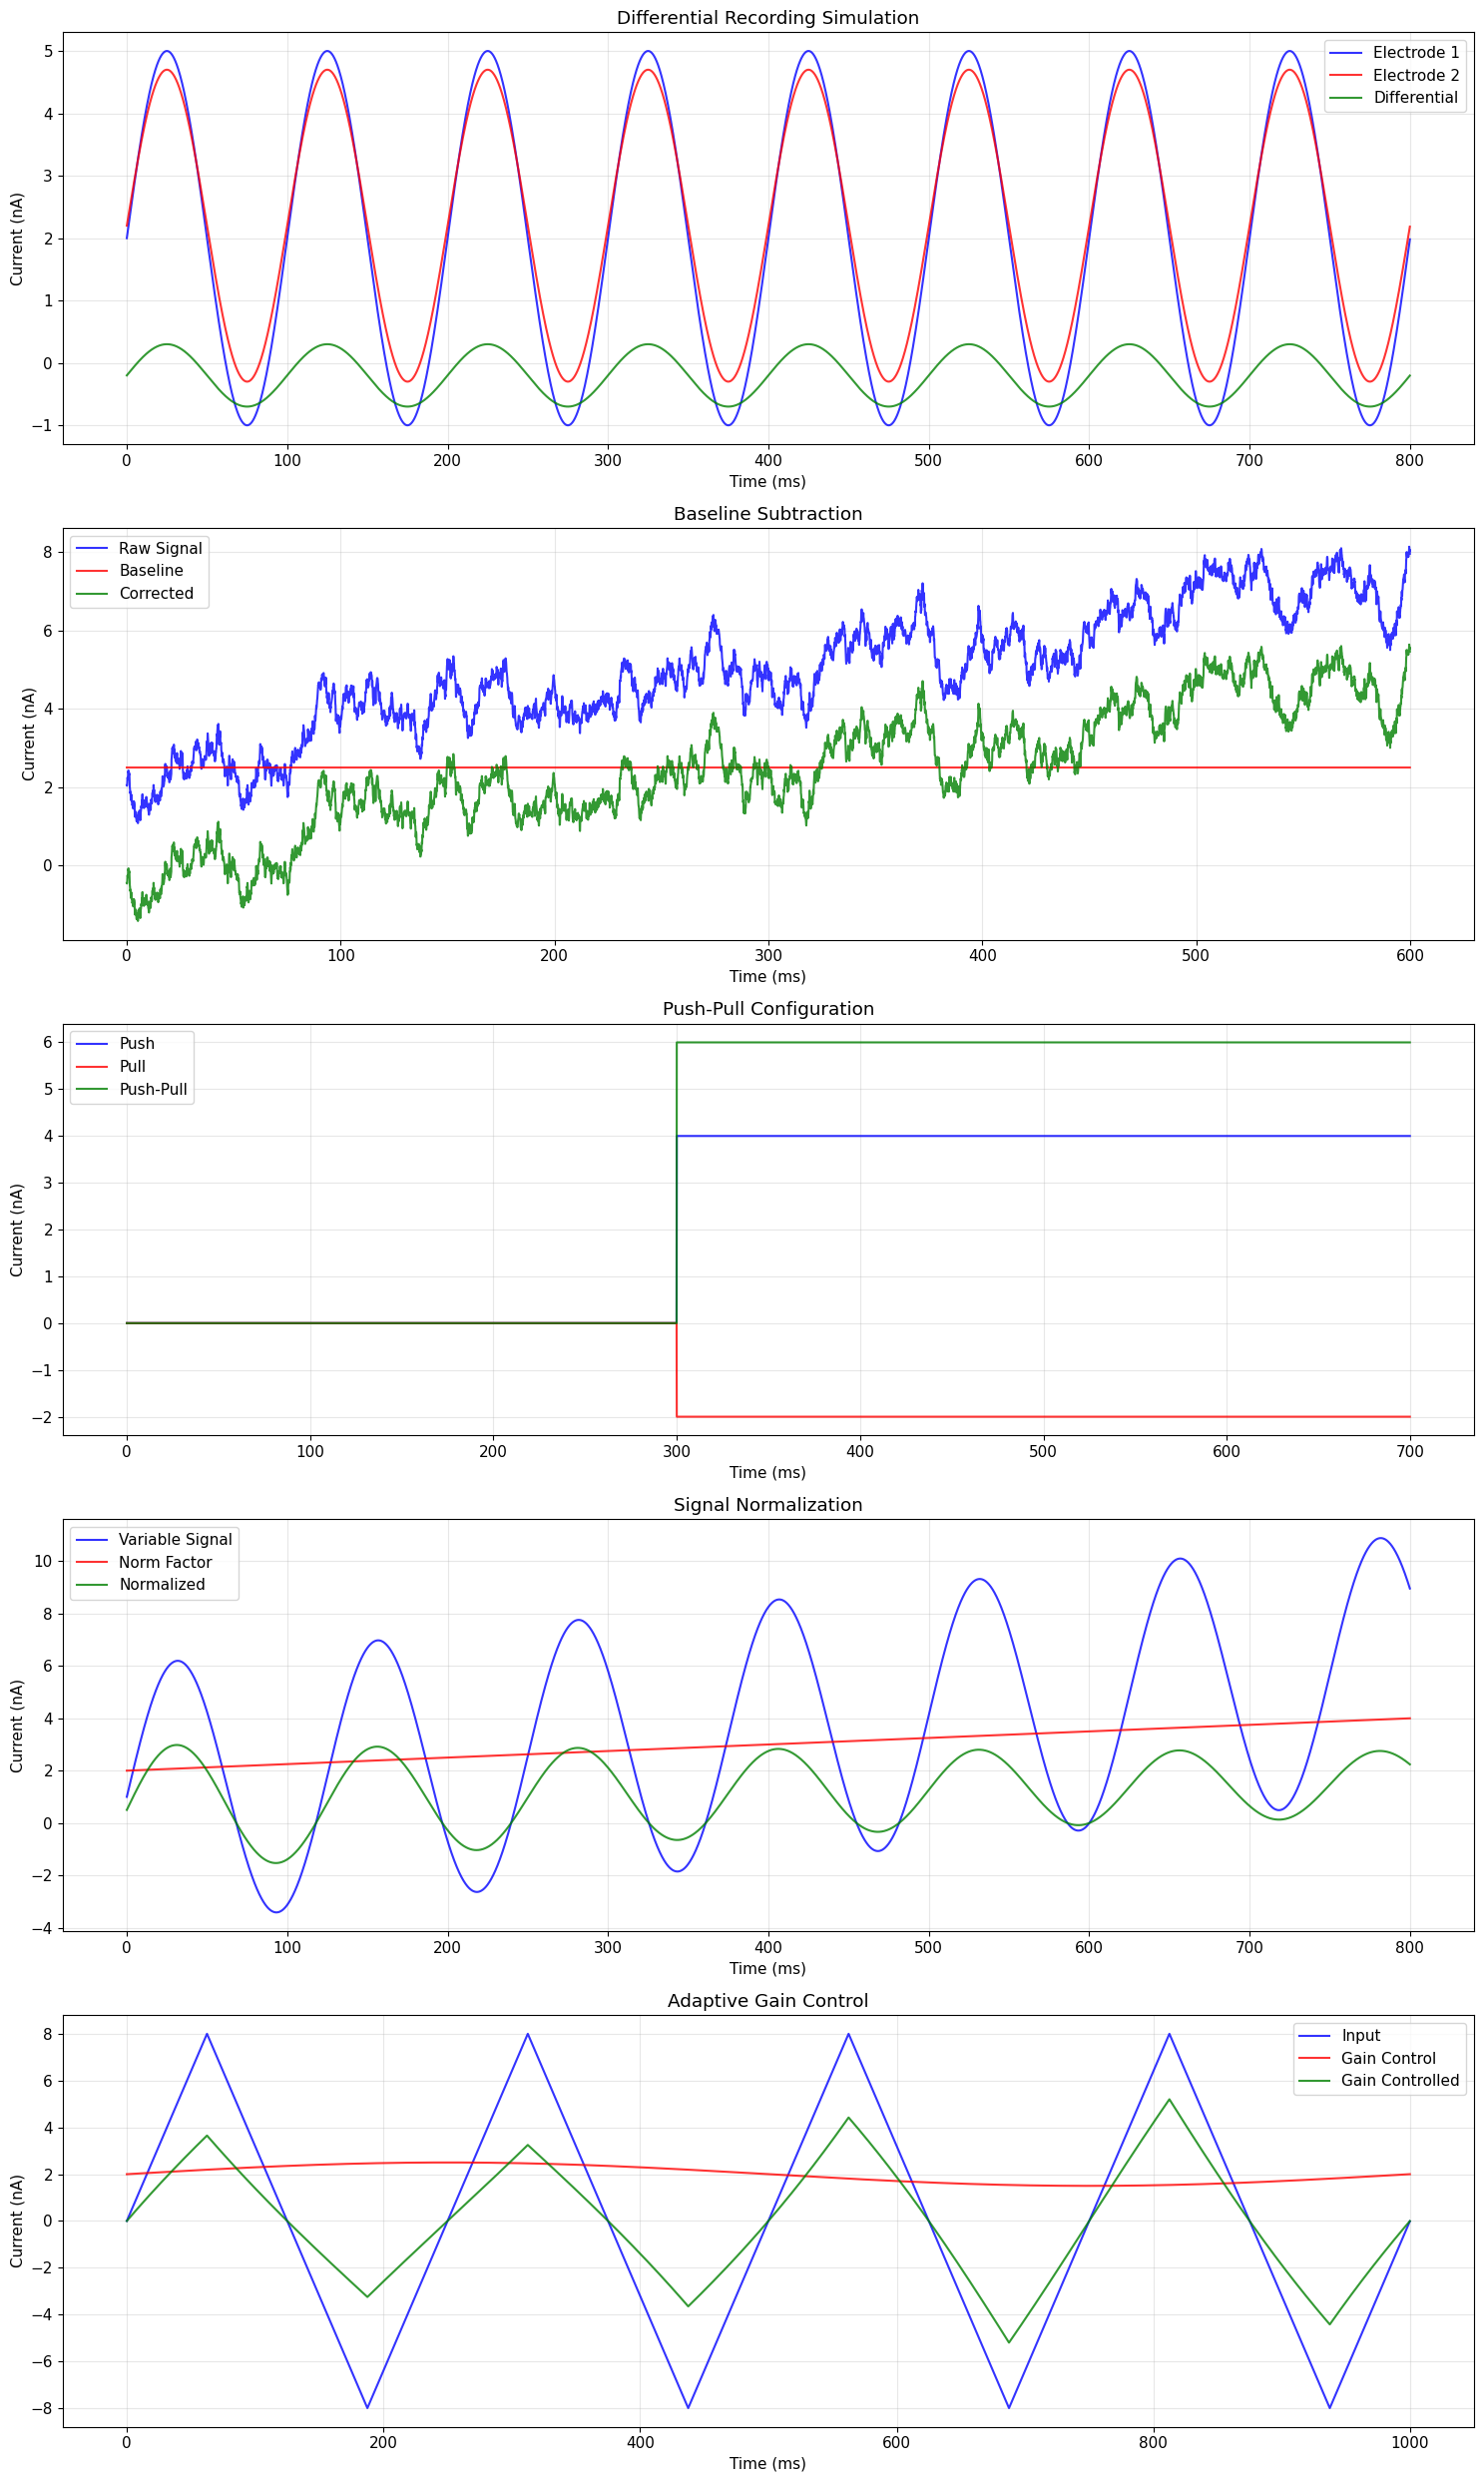

Subtraction and Division features:
- Subtraction: useful for differential measurements, baseline correction
- Division: useful for normalization, gain control
- Be careful with division by zero or very small numbers
- Order matters: a - b ≠ b - a, a / b ≠ b / a


In [45]:
with brainstate.environ.context(dt=dt):
    # Subtraction examples

    # Example 1: Differential recording simulation
    signal_electrode1 = braintools.input.Sinusoidal(3.0, 10 * u.Hz, 800 * u.ms) + braintools.input.Constant(
        [(2.0, 800 * u.ms)])
    signal_electrode2 = braintools.input.Sinusoidal(2.5, 10 * u.Hz, 800 * u.ms) + braintools.input.Constant(
        [(2.2, 800 * u.ms)])
    differential = signal_electrode1 - signal_electrode2

    # Example 2: Baseline subtraction
    raw_signal = braintools.input.Ramp(2, 8, 600 * u.ms) + braintools.input.OUProcess(
        mean=0., sigma=0.3, tau=10 * u.ms, duration=600 * u.ms, seed=42)
    baseline = braintools.input.Constant([(2.5, 600 * u.ms)])
    corrected_signal = raw_signal - baseline

    # Example 3: Push-pull configuration
    push_signal = braintools.input.Step([0, 4, 0], [200, 300, 200] * u.ms, 700 * u.ms)
    pull_signal = braintools.input.Step([0, -2, 0], [200, 300, 200] * u.ms, 700 * u.ms)
    push_pull = push_signal - pull_signal  # Amplifies difference

    # Division examples

    # Example 4: Normalization
    variable_signal = braintools.input.Sinusoidal(5.0, 8 * u.Hz, 800 * u.ms) + braintools.input.Ramp(1, 6, 800 * u.ms)
    normalization_factor = braintools.input.Ramp(2, 4, 800 * u.ms)  # Increasing normalization
    normalized = variable_signal / normalization_factor

    # Example 5: Gain control
    input_signal = braintools.input.Triangular(8.0, 4 * u.Hz, 1000 * u.ms)
    gain_control = braintools.input.Sinusoidal(0.5, 1 * u.Hz, 1000 * u.ms, bias=True) + braintools.input.Constant(
        [(1.5, 1000 * u.ms)])
    gain_controlled = input_signal / gain_control

# Plot subtraction and division examples
examples = [
    {
        'signals': [(signal_electrode1(), 'Electrode 1'), (signal_electrode2(), 'Electrode 2'),
                    (differential(), 'Differential')],
        'duration': 800 * u.ms,
        'title': 'Differential Recording Simulation'
    },
    {
        'signals': [(raw_signal(), 'Raw Signal'), (baseline(), 'Baseline'), (corrected_signal(), 'Corrected')],
        'duration': 600 * u.ms,
        'title': 'Baseline Subtraction'
    },
    {
        'signals': [(push_signal(), 'Push'), (pull_signal(), 'Pull'), (push_pull(), 'Push-Pull')],
        'duration': 700 * u.ms,
        'title': 'Push-Pull Configuration'
    },
    {
        'signals': [(variable_signal(), 'Variable Signal'), (normalization_factor(), 'Norm Factor'),
                    (normalized(), 'Normalized')],
        'duration': 800 * u.ms,
        'title': 'Signal Normalization'
    },
    {
        'signals': [(input_signal(), 'Input'), (gain_control(), 'Gain Control'),
                    (gain_controlled(), 'Gain Controlled')],
        'duration': 1000 * u.ms,
        'title': 'Adaptive Gain Control'
    }
]

fig, axes = plt.subplots(5, 1, figsize=(15, 25))
colors = ['blue', 'red', 'green']

for i, example in enumerate(examples):
    ax = axes[i]
    for j, (signal, label) in enumerate(example['signals']):
        plot_signal(signal, example['duration'], example['title'], ax,
                    color=colors[j], label=label, alpha=0.8)
    ax.legend()

plt.tight_layout()
plt.show()

print("Subtraction and Division features:")
print("- Subtraction: useful for differential measurements, baseline correction")
print("- Division: useful for normalization, gain control")
print("- Be careful with division by zero or very small numbers")
print("- Order matters: a - b ≠ b - a, a / b ≠ b / a")

## 3. Input Transformations

The composable API provides powerful transformation methods to modify signals.

### 3.1 Clipping and Scaling

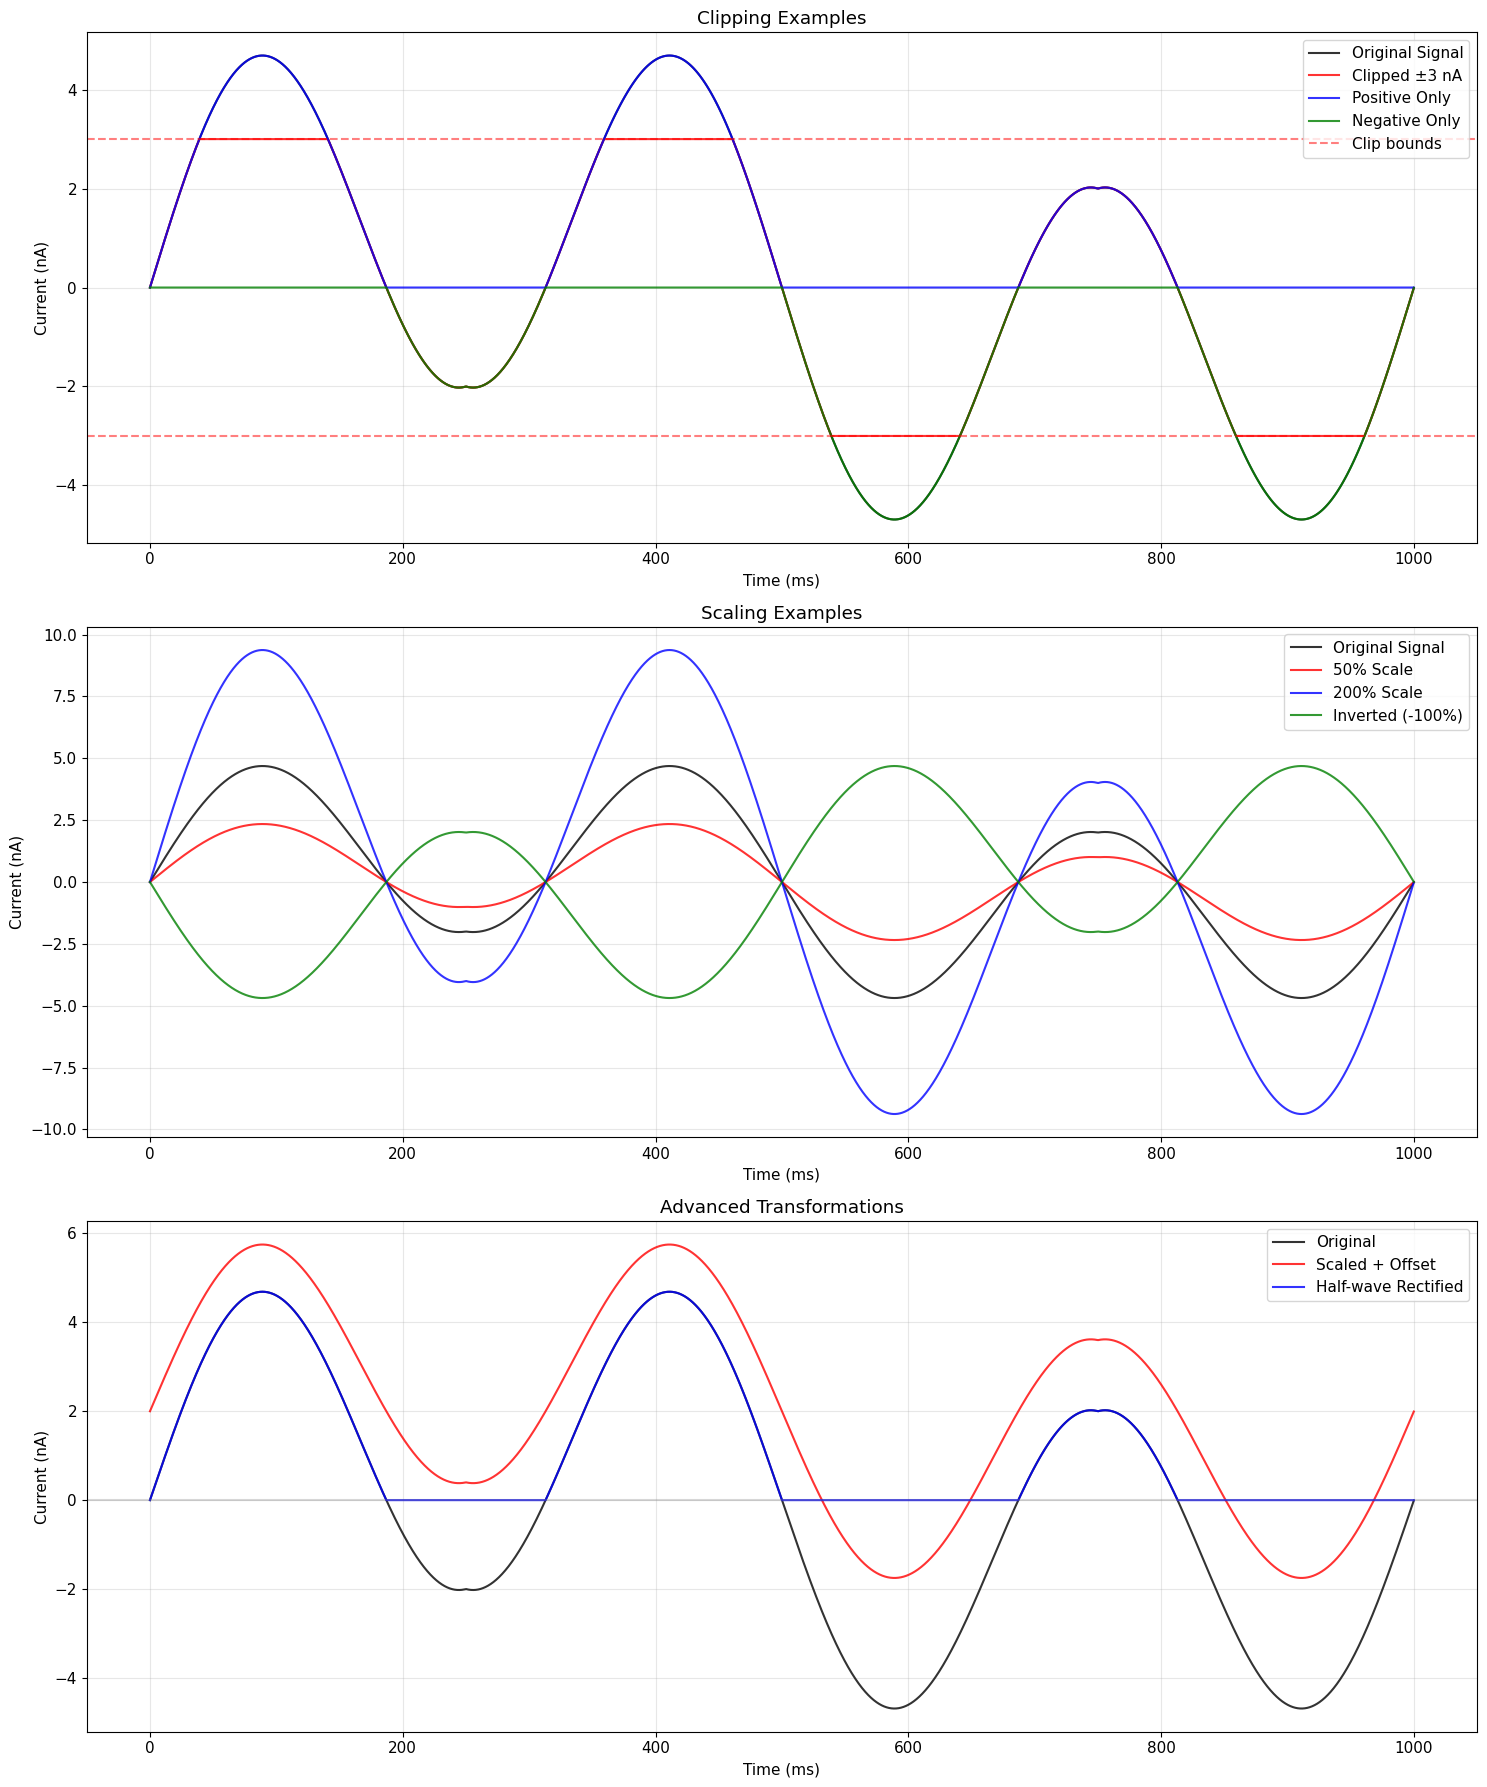

Clipping and Scaling methods:
- signal.clip(min_val, max_val): bounds signal between limits
- signal.scale(factor): multiplies by constant factor
- Use np.inf for unbounded clipping
- Combine with addition for offset + scale operations
- Useful for implementing current limits, gain control


In [46]:
with brainstate.environ.context(dt=dt):
    # Create a test signal with wide amplitude range
    base_signal = braintools.input.Sinusoidal(4.0, 3 * u.Hz, 1000 * u.ms) + \
                  braintools.input.Triangular(2.0, 1 * u.Hz, 1000 * u.ms)

    # Clipping operations
    clipped_symmetric = base_signal.clip(-3.0, 3.0)  # Symmetric clipping
    clipped_positive = base_signal.clip(0, 10.0)  # Only positive values
    clipped_negative = base_signal.clip(-10.0, 0)  # Only negative values

    # Scaling operations  
    scaled_half = base_signal.scale(0.5)  # 50% scaling
    scaled_double = base_signal.scale(2.0)  # 200% scaling
    scaled_negative = base_signal.scale(-1.0)  # Inversion

    # Advanced scaling with offset
    offset_signal = base_signal.scale(0.8) + braintools.input.Constant([(2.0, 1000 * u.ms)])

    # Rectification (absolute value)
    rectified = base_signal.clip(0, np.inf)  # Half-wave rectification
    # full_rectified = abs(base_signal)  # Full-wave rectification (if supported)

# Generate signals
original = base_signal()

clipping_examples = [
    (original, 'Original Signal'),
    (clipped_symmetric(), 'Clipped ±3 nA'),
    (clipped_positive(), 'Positive Only'),
    (clipped_negative(), 'Negative Only')
]

scaling_examples = [
    (original, 'Original Signal'),
    (scaled_half(), '50% Scale'),
    (scaled_double(), '200% Scale'),
    (scaled_negative(), 'Inverted (-100%)')
]

advanced_examples = [
    (original, 'Original'),
    (offset_signal(), 'Scaled + Offset'),
    (rectified(), 'Half-wave Rectified')
]

# Plot clipping and scaling examples
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Clipping examples
colors = ['black', 'red', 'blue', 'green']
ax = axes[0]
for i, (signal, label) in enumerate(clipping_examples):
    plot_signal(signal, 1000 * u.ms, 'Clipping Examples', ax,
                color=colors[i], label=label, alpha=0.8)
ax.axhline(y=3, color='red', linestyle='--', alpha=0.5, label='Clip bounds')
ax.axhline(y=-3, color='red', linestyle='--', alpha=0.5)
ax.legend()

# Scaling examples
ax = axes[1]
for i, (signal, label) in enumerate(scaling_examples):
    plot_signal(signal, 1000 * u.ms, 'Scaling Examples', ax,
                color=colors[i], label=label, alpha=0.8)
ax.legend()

# Advanced examples
ax = axes[2]
for i, (signal, label) in enumerate(advanced_examples):
    plot_signal(signal, 1000 * u.ms, 'Advanced Transformations', ax,
                color=colors[i], label=label, alpha=0.8)
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("Clipping and Scaling methods:")
print("- signal.clip(min_val, max_val): bounds signal between limits")
print("- signal.scale(factor): multiplies by constant factor")
print("- Use np.inf for unbounded clipping")
print("- Combine with addition for offset + scale operations")
print("- Useful for implementing current limits, gain control")

### 3.2 Smoothing and Filtering

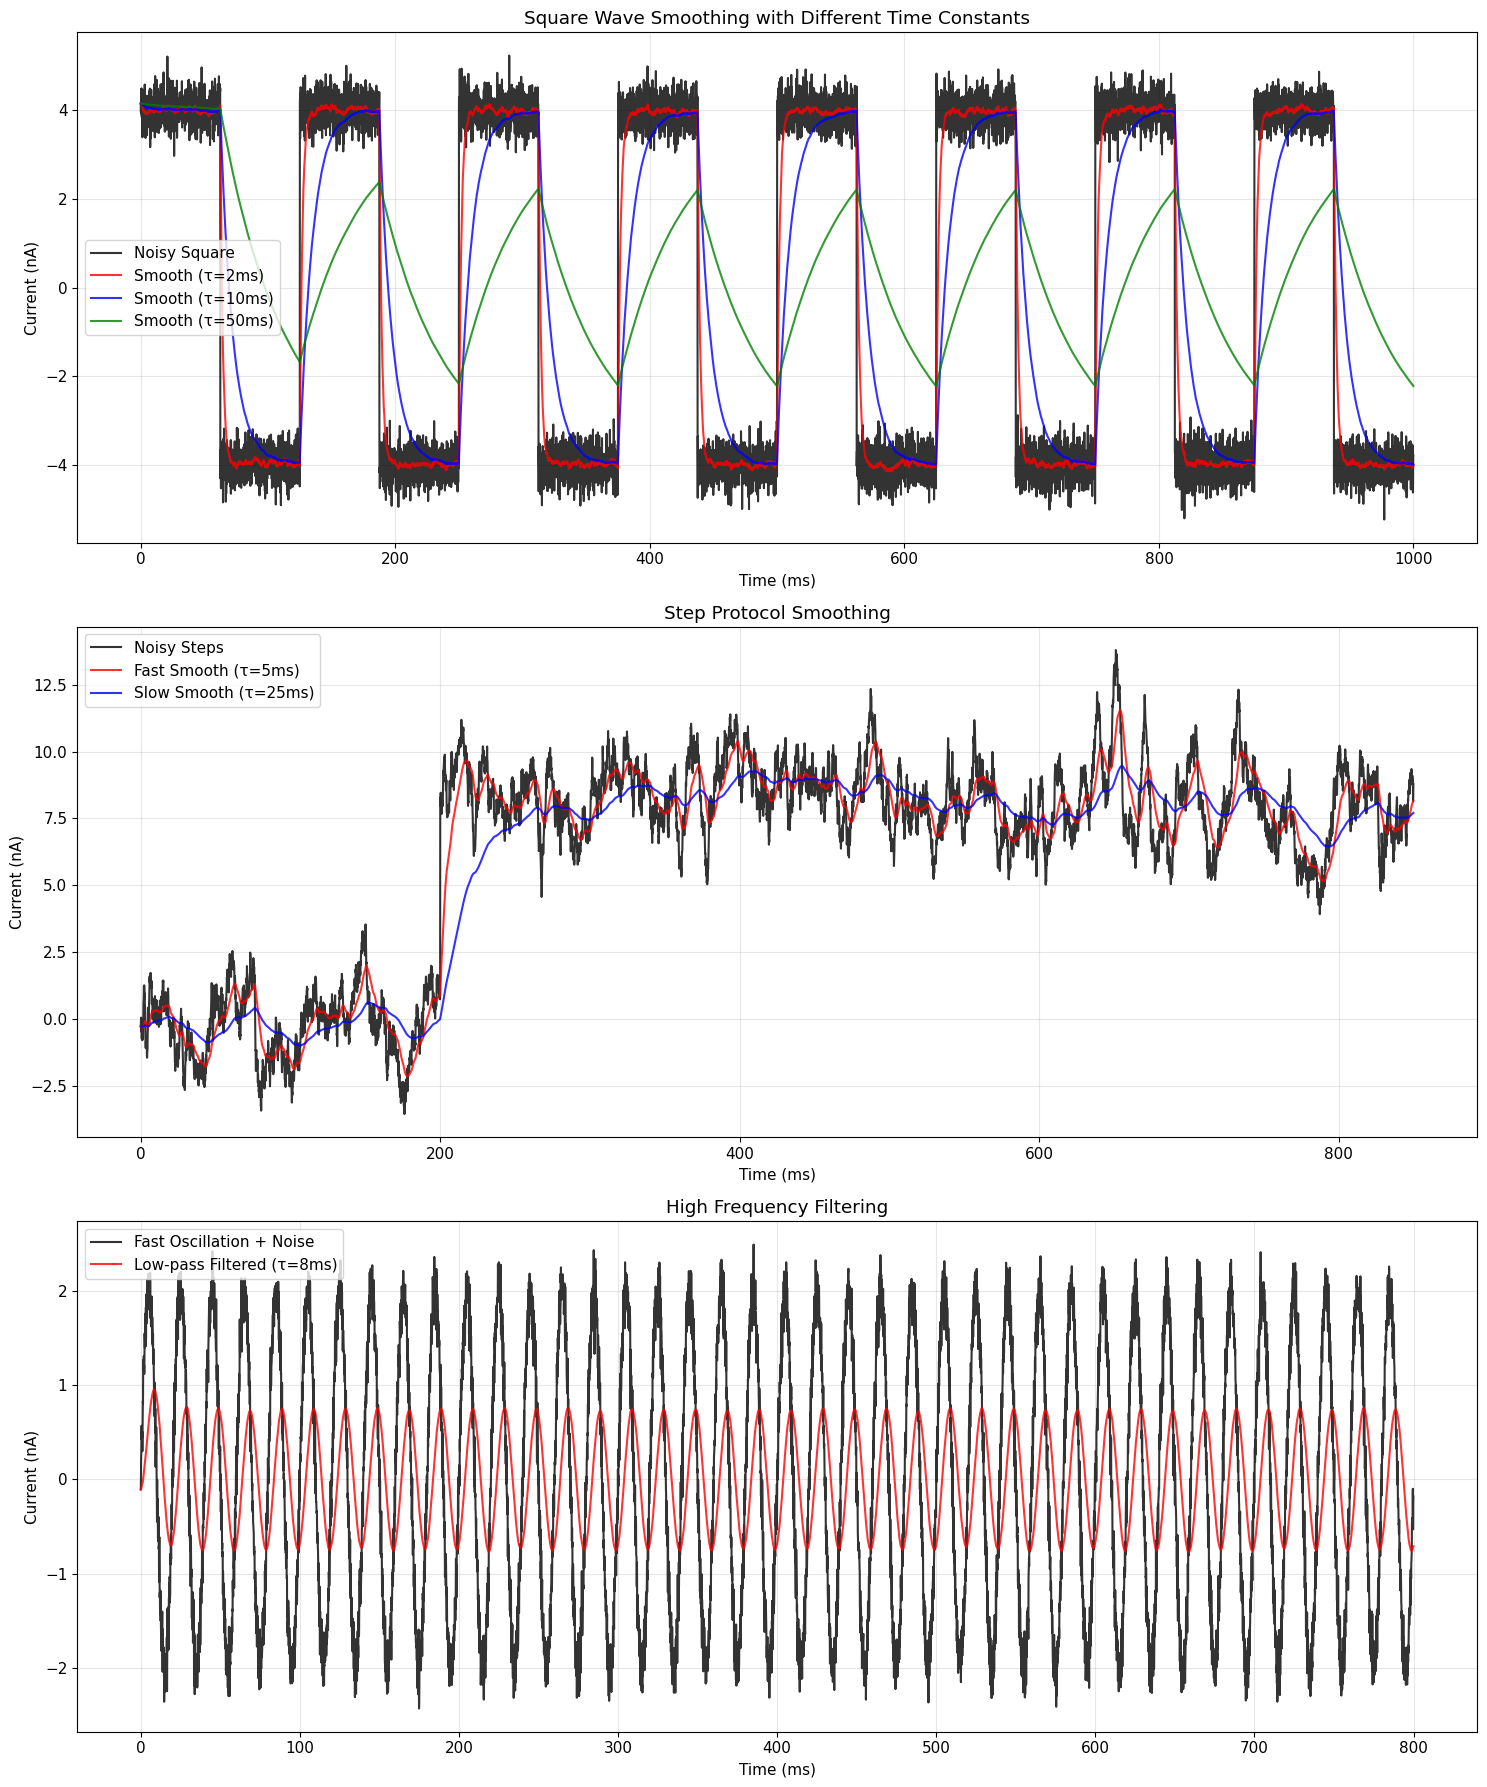

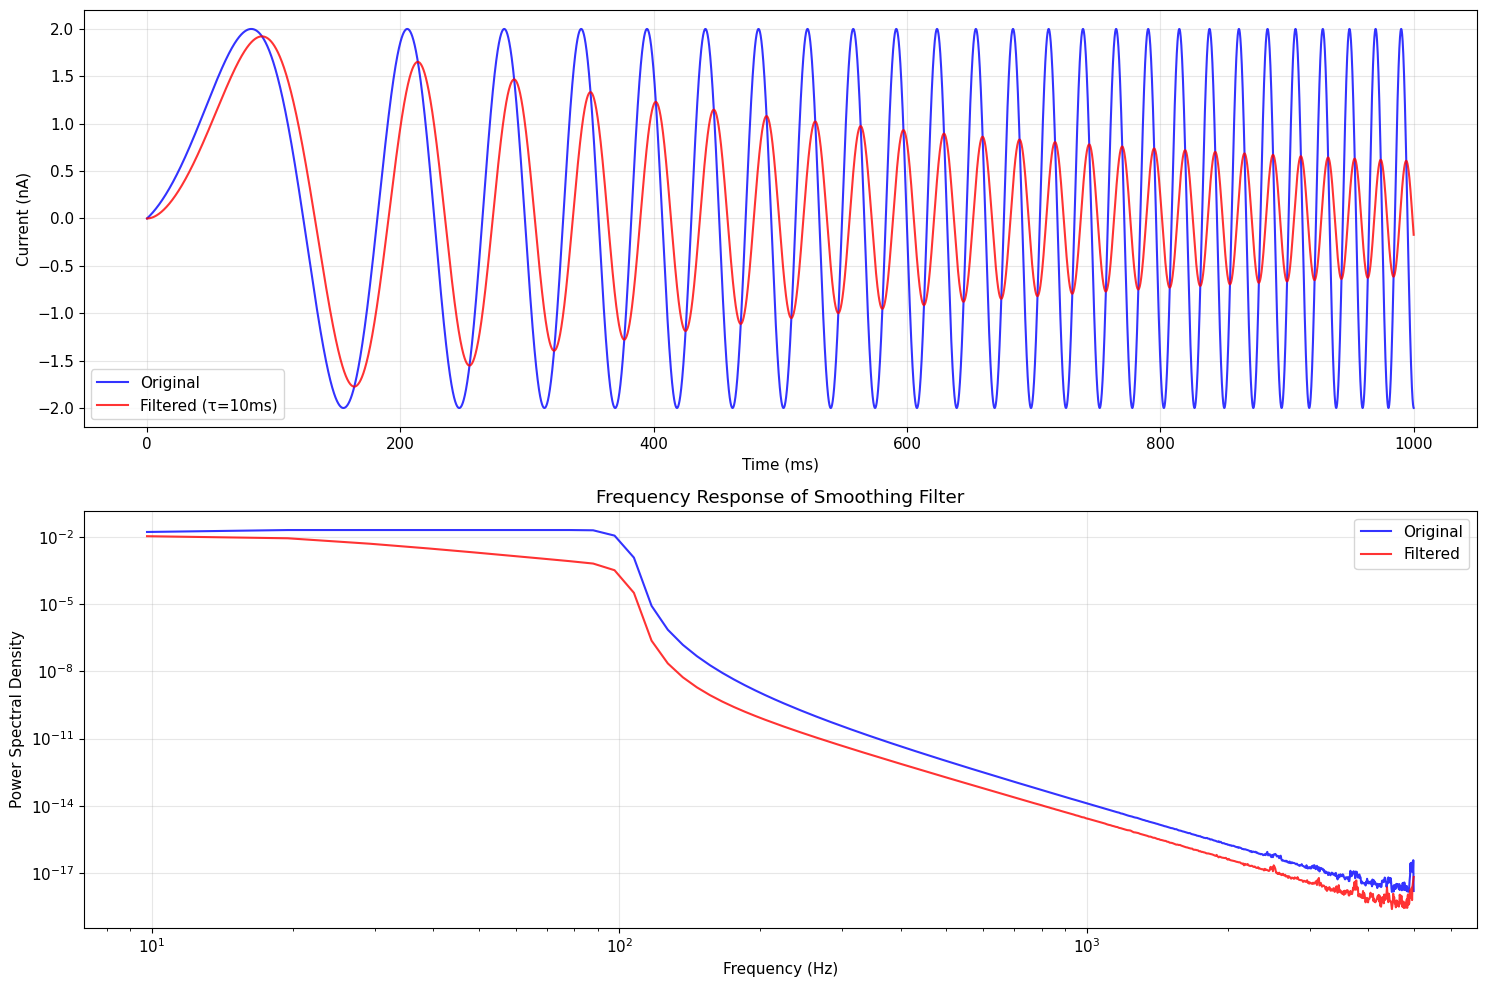

Smoothing features:
- signal.smooth(tau): exponential smoothing with time constant tau
- Acts as low-pass filter with cutoff ≈ 1/(2π·tau)
- Larger tau = more smoothing, lower cutoff frequency
- Useful for removing noise, simulating membrane filtering
- τ=10ms corresponds to cutoff ≈ 15.9 Hz


In [47]:
with brainstate.environ.context(dt=dt):
    # Create test signals for filtering
    noisy_square = braintools.input.Square(4.0, 8 * u.Hz, 1000 * u.ms) + \
                   braintools.input.WienerProcess(sigma=1.0, duration=1000 * u.ms, seed=42)
    noisy_step = braintools.input.Step([0, 6, 0, 8, 0], [150, 200, 150, 200, 150] * u.ms, 850 * u.ms) + \
                 braintools.input.OUProcess(mean=0., sigma=0.8, tau=5 * u.ms, duration=850 * u.ms, seed=123)

    # High frequency oscillation with noise
    fast_osc = braintools.input.Sinusoidal(2.0, 50 * u.Hz, 800 * u.ms) + \
               braintools.input.WienerProcess(sigma=0.5, duration=800 * u.ms, seed=456)

    # Different smoothing time constants
    smooth_fast = noisy_square.smooth(tau=2 * u.ms)  # Fast smoothing (minimal)
    smooth_medium = noisy_square.smooth(tau=10 * u.ms)  # Medium smoothing
    smooth_slow = noisy_square.smooth(tau=50 * u.ms)  # Slow smoothing (heavy)

    # Step response smoothing
    step_smooth_fast = noisy_step.smooth(tau=5 * u.ms)
    step_smooth_slow = noisy_step.smooth(tau=25 * u.ms)

    # High frequency filtering
    osc_filtered = fast_osc.smooth(tau=8 * u.ms)  # Low-pass filter

# Generate signals
smoothing_examples = [
    {
        'signals': [
            (noisy_square(), 'Noisy Square'),
            (smooth_fast(), 'Smooth (τ=2ms)'),
            (smooth_medium(), 'Smooth (τ=10ms)'),
            (smooth_slow(), 'Smooth (τ=50ms)')
        ],
        'duration': 1000 * u.ms,
        'title': 'Square Wave Smoothing with Different Time Constants'
    },
    {
        'signals': [
            (noisy_step(), 'Noisy Steps'),
            (step_smooth_fast(), 'Fast Smooth (τ=5ms)'),
            (step_smooth_slow(), 'Slow Smooth (τ=25ms)')
        ],
        'duration': 850 * u.ms,
        'title': 'Step Protocol Smoothing'
    },
    {
        'signals': [
            (fast_osc(), 'Fast Oscillation + Noise'),
            (osc_filtered(), 'Low-pass Filtered (τ=8ms)')
        ],
        'duration': 800 * u.ms,
        'title': 'High Frequency Filtering'
    }
]

# Plot smoothing examples
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

colors = ['black', 'red', 'blue', 'green', 'purple']

for i, example in enumerate(smoothing_examples):
    ax = axes[i]
    for j, (signal, label) in enumerate(example['signals']):
        plot_signal(signal, example['duration'], example['title'], ax,
                    color=colors[j], label=label, alpha=0.8)
    ax.legend()

plt.tight_layout()
plt.show()

# Demonstrate frequency response of smoothing
with brainstate.environ.context(dt=dt):
    # Test with chirp signal
    test_chirp = braintools.input.Chirp(2.0, 1 * u.Hz, 100 * u.Hz, 2000 * u.ms)
    chirp_original = test_chirp()
    chirp_filtered = test_chirp.smooth(tau=10 * u.ms)()

# Analyze frequency response
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Time domain
plot_signal(chirp_original[:10000], 1000 * u.ms, 'Chirp Signal: Original vs Filtered', ax1,
            color='blue', label='Original', alpha=0.8)
plot_signal(chirp_filtered[:10000], 1000 * u.ms, '', ax1,
            color='red', label='Filtered (τ=10ms)', alpha=0.8)
ax1.legend()

# Frequency domain
dt_val = u.get_magnitude(dt)
fs = 1000 / dt_val  # Sampling frequency
f_orig, psd_orig = scipy_signal.welch(u.get_magnitude(chirp_original), fs=fs, nperseg=1024)
f_filt, psd_filt = scipy_signal.welch(u.get_magnitude(chirp_filtered), fs=fs, nperseg=1024)

ax2.loglog(f_orig[1:], psd_orig[1:], 'b-', label='Original', alpha=0.8)
ax2.loglog(f_filt[1:], psd_filt[1:], 'r-', label='Filtered', alpha=0.8)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power Spectral Density')
ax2.set_title('Frequency Response of Smoothing Filter')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Smoothing features:")
print("- signal.smooth(tau): exponential smoothing with time constant tau")
print("- Acts as low-pass filter with cutoff ≈ 1/(2π·tau)")
print("- Larger tau = more smoothing, lower cutoff frequency")
print("- Useful for removing noise, simulating membrane filtering")
print(f"- τ=10ms corresponds to cutoff ≈ {1000 / (2 * np.pi * 10):.1f} Hz")

### 3.3 Time Shifting and Repetition

C:\Users\adadu\miniconda3\envs\bdp\Lib\site-packages\saiunit\math\_fun_array_creation.py:293: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.zeros(shape, dtype=dtype)


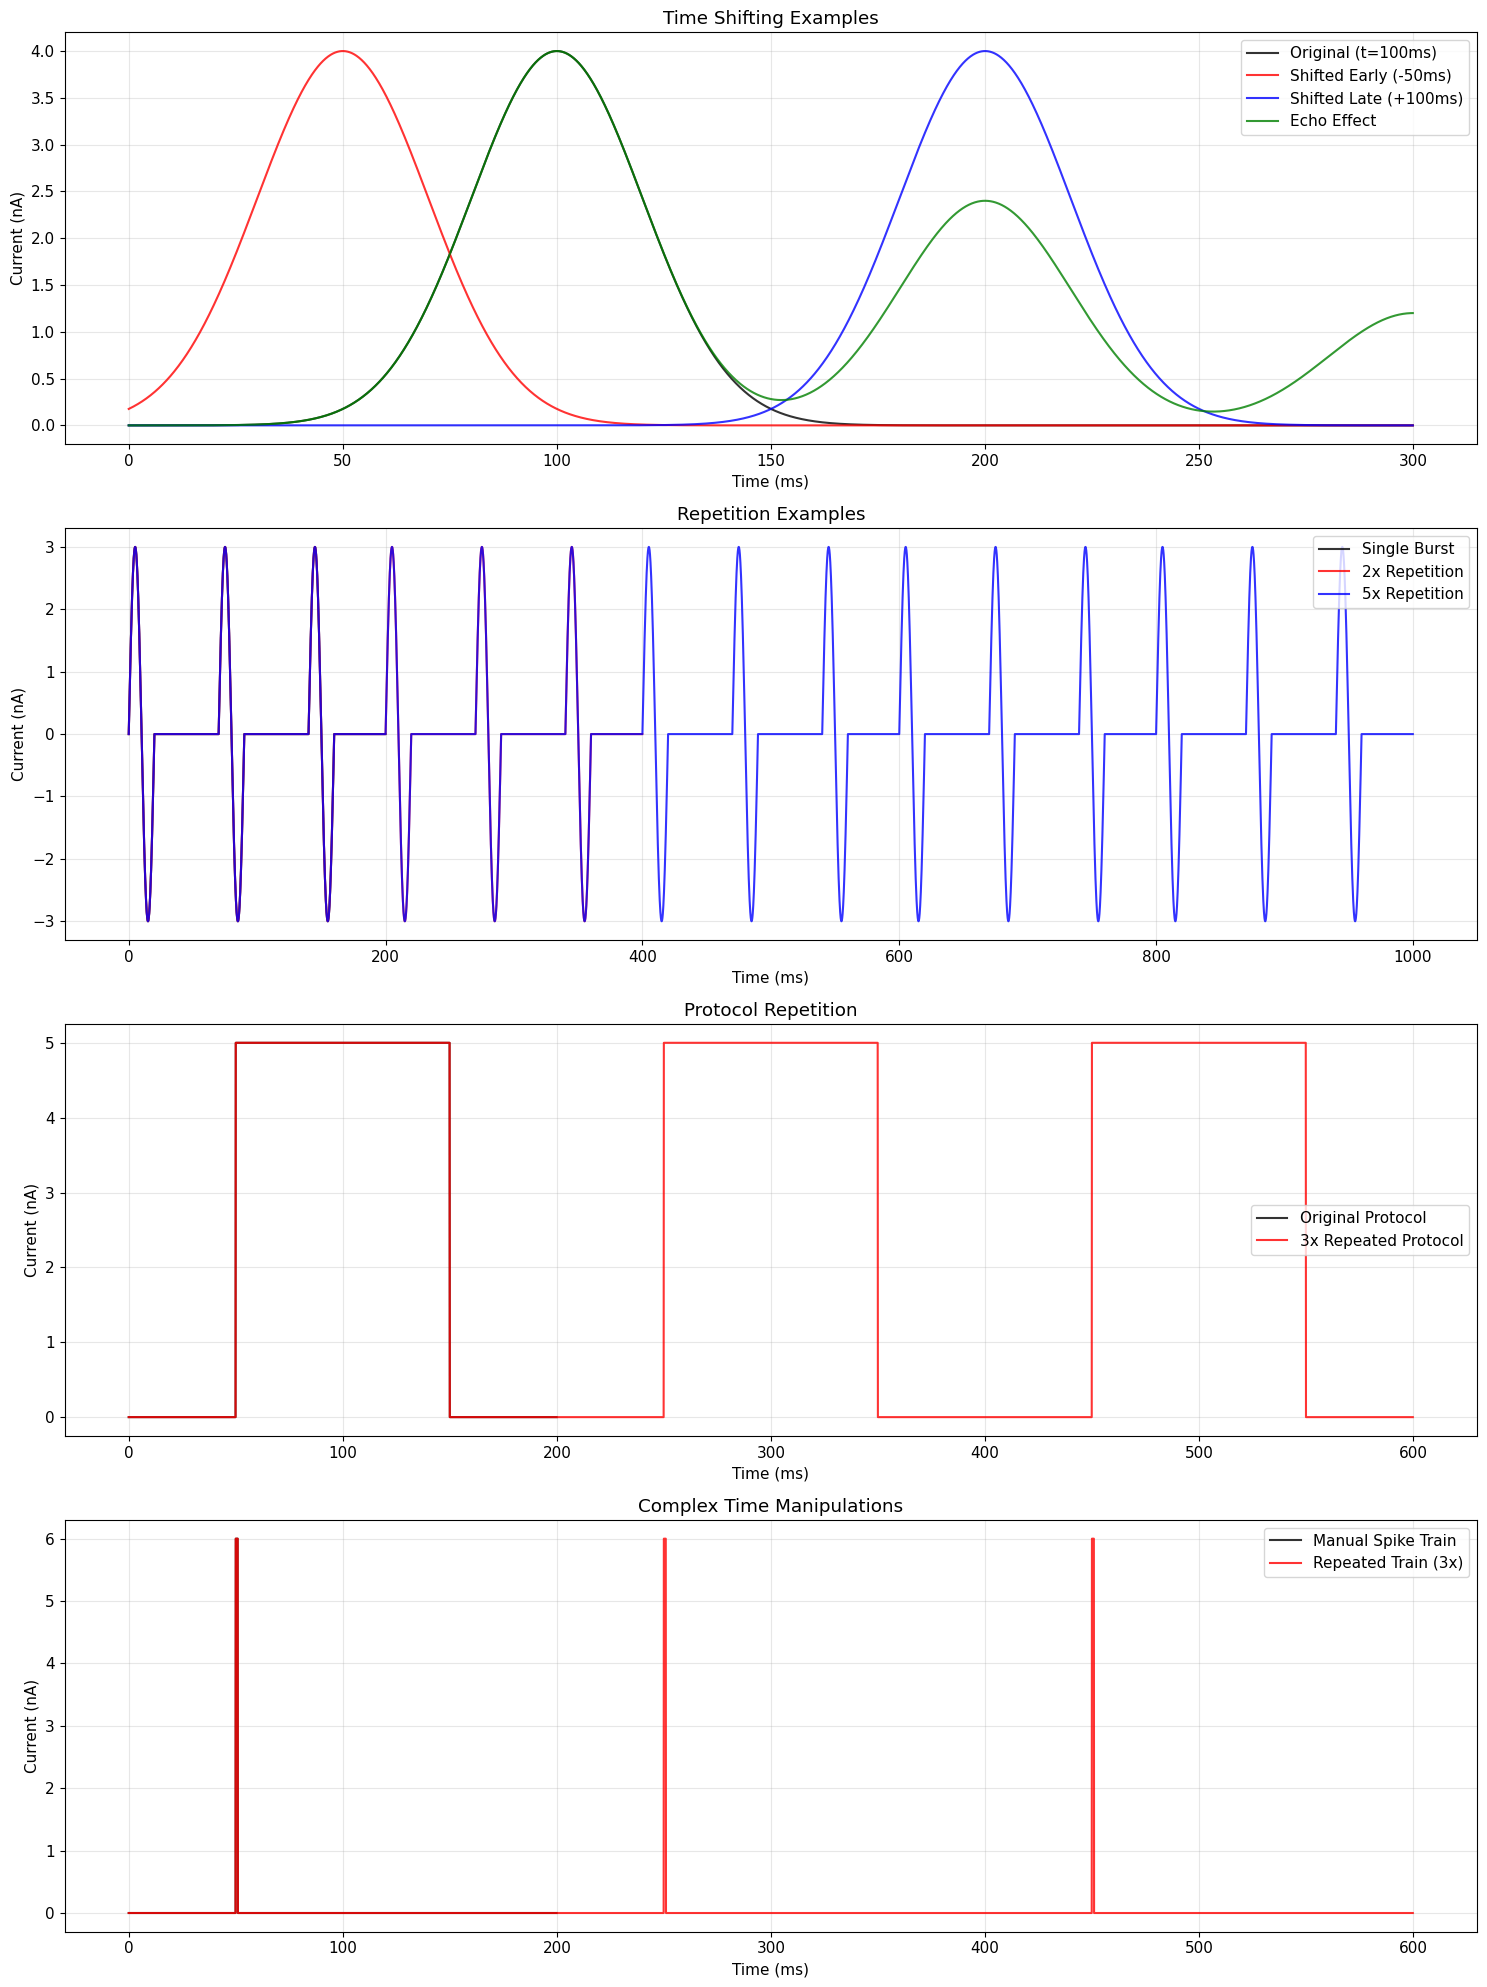

Time manipulation features:
- signal.shift(delay): time shift by delay amount
  - Positive delay: shifts signal later in time
  - Negative delay: shifts signal earlier in time
- signal.repeat(n): repeats signal n times sequentially
- Combine for complex temporal patterns
- Useful for: echoes, spike trains, protocol repetition


In [48]:
with brainstate.environ.context(dt=dt):
    # Create a distinctive test signal
    test_pulse = braintools.input.GaussianPulse(center=100 * u.ms, duration=300 * u.ms, sigma=20 * u.ms, amplitude=4.0)

    # Time shifting examples
    original = test_pulse
    shifted_early = test_pulse.shift(-50 * u.ms)  # Shift earlier (negative delay)
    shifted_late = test_pulse.shift(100 * u.ms)  # Shift later (positive delay)

    # Multiple shifts for echo effects
    echo_signal = original + shifted_late.scale(0.6) + test_pulse.shift(200 * u.ms).scale(0.3)

    # Repetition examples
    single_burst = braintools.input.Burst(inter_burst_interval=50 * u.ms, burst_duration=20 * u.ms, n_bursts=4,
                                          burst_freq=50 * u.Hz, burst_amp=3.0, duration=200 * u.ms)
    repeated_2x = single_burst.repeat(2)
    repeated_5x = single_burst.repeat(5)

    # Complex repetition with different signals
    short_protocol = braintools.input.Section(
        [0, 5, 0],
        [50 * u.ms, 100 * u.ms, 50 * u.ms]
    )
    protocol_3x = short_protocol.repeat(3)

    # Combine shifting and repetition
    base_spike = braintools.input.Spike([50 * u.ms], 150 * u.ms, sp_lens=1.0 * u.ms, sp_sizes=6.0)
    spike_train = base_spike + base_spike.shift(100 * u.ms) + base_spike.shift(200 * u.ms)
    train_repeated = spike_train.repeat(3)

# Generate signals for time manipulation examples
time_shift_examples = [
    (original(), 'Original (t=100ms)'),
    (shifted_early(), 'Shifted Early (-50ms)'),
    (shifted_late(), 'Shifted Late (+100ms)'),
    (echo_signal(), 'Echo Effect')
]

repetition_examples = [
    (single_burst(), 'Single Burst'),
    (repeated_2x(), '2x Repetition'),
    (repeated_5x(), '5x Repetition')
]

protocol_examples = [
    (short_protocol(), 'Original Protocol'),
    (protocol_3x(), '3x Repeated Protocol')
]

complex_examples = [
    (spike_train(), 'Manual Spike Train'),
    (train_repeated(), 'Repeated Train (3x)')
]

# Plot time manipulation examples
fig, axes = plt.subplots(4, 1, figsize=(15, 20))

colors = ['black', 'red', 'blue', 'green']

# Time shifting
ax = axes[0]
for i, (signal, label) in enumerate(time_shift_examples):
    # Extend duration to see all shifts
    extended_duration = 500 * u.ms
    plot_signal(signal, extended_duration, 'Time Shifting Examples', ax,
                color=colors[i], label=label, alpha=0.8)
ax.legend()

# Repetition
ax = axes[1]
durations = [200 * u.ms, 400 * u.ms, 1000 * u.ms]
for i, (signal, label) in enumerate(repetition_examples):
    plot_signal(signal, durations[i], 'Repetition Examples', ax,
                color=colors[i], label=label, alpha=0.8)
ax.legend()

# Protocol repetition
ax = axes[2]
for i, (signal, label) in enumerate(protocol_examples):
    duration = 200 * u.ms if i == 0 else 600 * u.ms
    plot_signal(signal, duration, 'Protocol Repetition', ax,
                color=colors[i], label=label, alpha=0.8)
ax.legend()

# Complex combinations
ax = axes[3]
for i, (signal, label) in enumerate(complex_examples):
    duration = 450 * u.ms if i == 0 else 1350 * u.ms  # 3x duration for repeated
    plot_signal(signal, duration, 'Complex Time Manipulations', ax,
                color=colors[i], label=label, alpha=0.8)
ax.legend()

plt.tight_layout()
plt.show()

print("Time manipulation features:")
print("- signal.shift(delay): time shift by delay amount")
print("  - Positive delay: shifts signal later in time")
print("  - Negative delay: shifts signal earlier in time")
print("- signal.repeat(n): repeats signal n times sequentially")
print("- Combine for complex temporal patterns")
print("- Useful for: echoes, spike trains, protocol repetition")

## 4. Sequential and Parallel Combinations

Advanced ways to combine multiple inputs in time and space.

### 4.1 Sequential Combinations

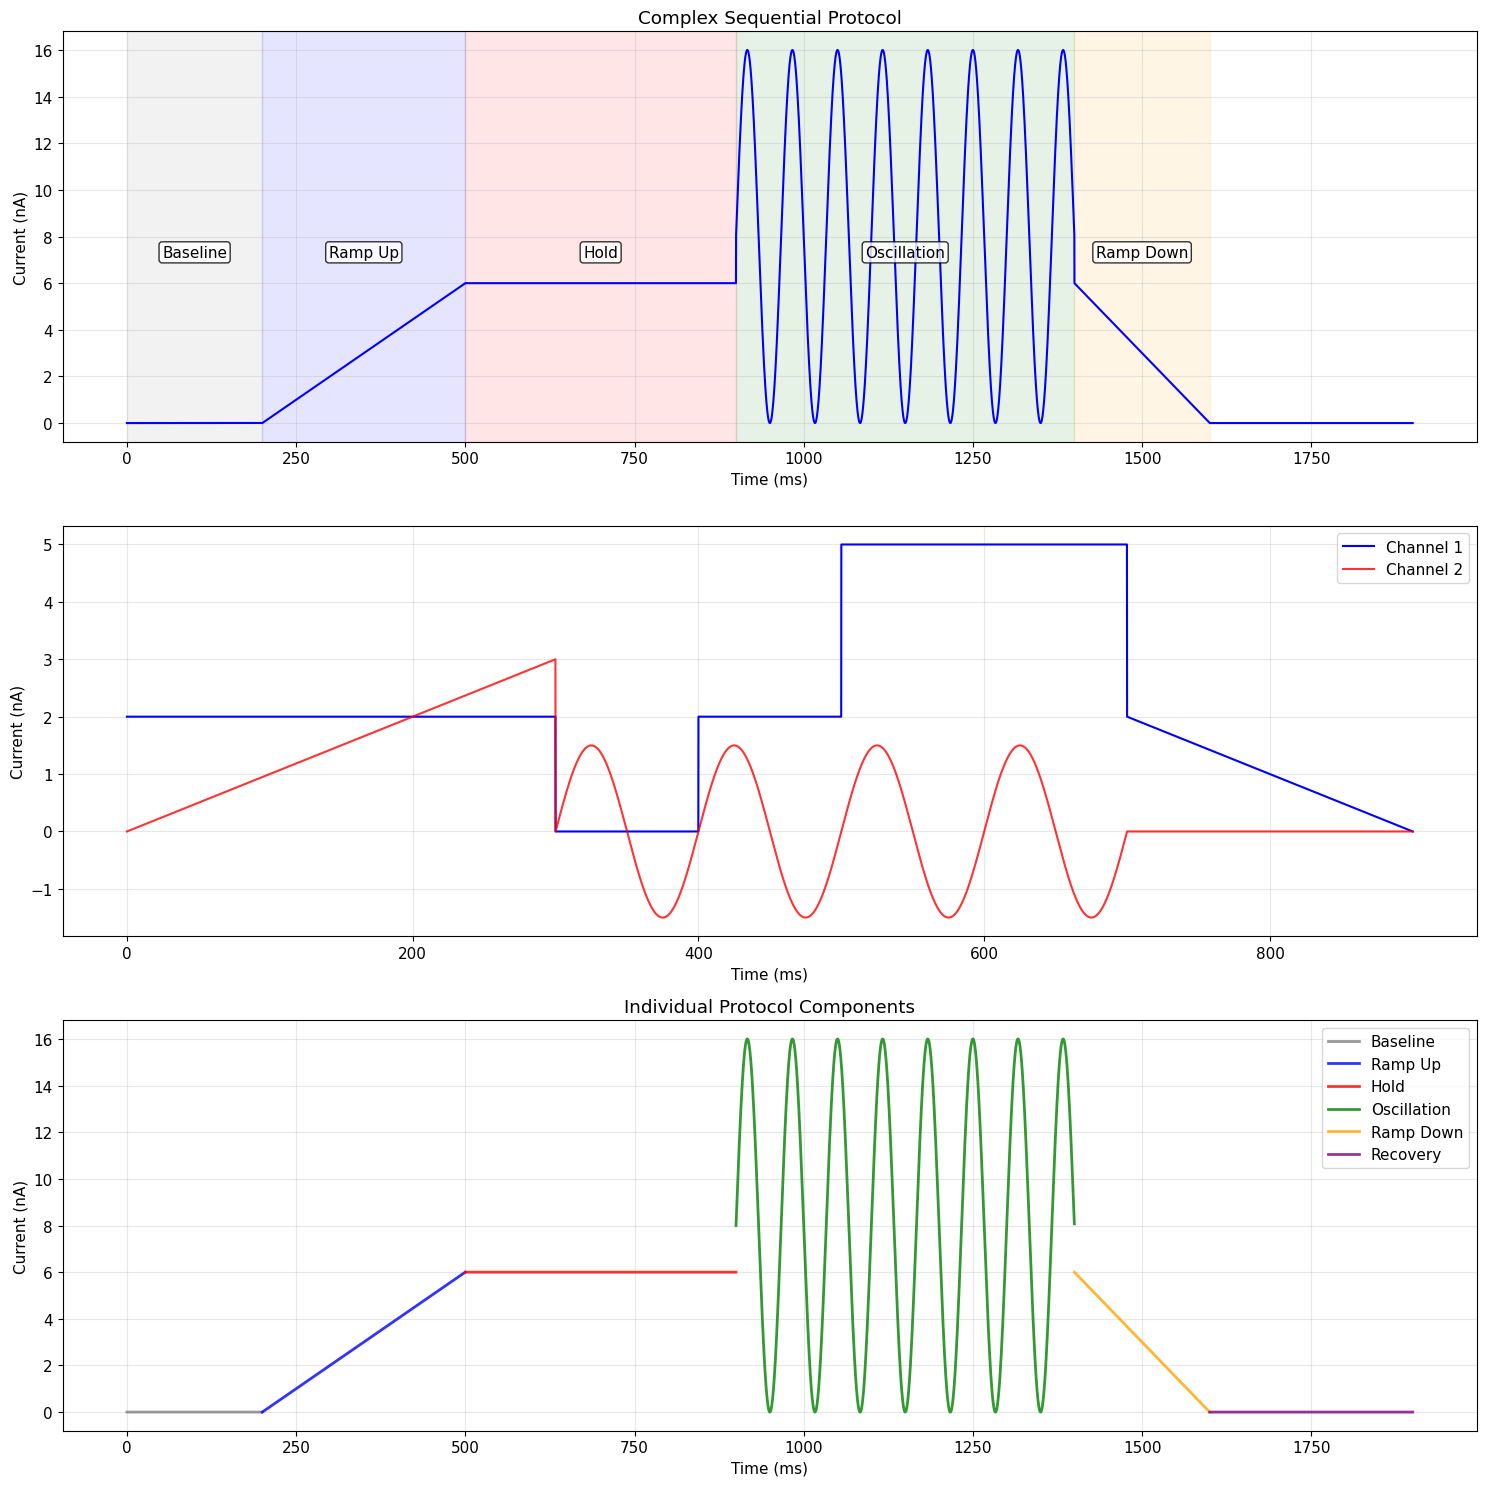

Sequential combination features:
- braintools.input.Sequential([input1, input2, ...]): automatic concatenation
- Manual concatenation with numpy for more control
- Each phase can have different duration and complexity
- Useful for multi-phase experimental protocols
- Total protocol duration: 1900 ms


In [50]:
with brainstate.environ.context(dt=dt):
    # Create individual protocol phases
    baseline = braintools.input.Constant([(0, 200 * u.ms)])
    ramp_up = braintools.input.Ramp(0, 6, 300 * u.ms)
    hold_high = braintools.input.Constant([(6, 400 * u.ms)])
    oscillation = braintools.input.Sinusoidal(2.0, 15 * u.Hz, 500 * u.ms, bias=True) * braintools.input.Constant(
        [(4.0, 500 * u.ms)])
    ramp_down = braintools.input.Ramp(6, 0, 200 * u.ms)
    recovery = braintools.input.Constant([(0, 300 * u.ms)])

    # Sequential combination using the Sequential class
    complex_protocol = braintools.input.Sequential(
        baseline,
        ramp_up,
        hold_high,
        oscillation,
        ramp_down,
        recovery
    )

    # Alternative: Manual concatenation (more control)
    manual_concat = (
        baseline &
        ramp_up &
        hold_high &
        oscillation &
        ramp_down &
        recovery
    )()

    # Multi-channel sequential protocol
    channel1_seq = braintools.input.Sequential(
        braintools.input.Constant([(2, 300 * u.ms)]),
        braintools.input.Step([2, 5, 2], [100, 200, 100] * u.ms, 400 * u.ms),
        braintools.input.Ramp(2, 0, 200 * u.ms)
    )

    channel2_seq = braintools.input.Sequential(
        braintools.input.Ramp(0, 3, 300 * u.ms),
        braintools.input.Sinusoidal(1.5, 10 * u.Hz, 400 * u.ms),
        braintools.input.Constant([(0, 200 * u.ms)])
    )

# Generate sequential signals
total_duration = 200 + 300 + 400 + 500 + 200 + 300  # 1900 ms

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

# Complex protocol
plot_signal(complex_protocol(), total_duration * u.ms, 'Complex Sequential Protocol', axes[0])

# Add phase annotations
phase_starts = [0, 200, 500, 900, 1400, 1600]
phase_labels = ['Baseline', 'Ramp Up', 'Hold', 'Oscillation', 'Ramp Down', 'Recovery']
colors_phases = ['gray', 'blue', 'red', 'green', 'orange', 'purple']

for i, (start, label, color) in enumerate(zip(phase_starts[:-1], phase_labels, colors_phases)):
    end = phase_starts[i + 1]
    axes[0].axvspan(start, end, alpha=0.1, color=color)
    axes[0].text(start + (end - start) / 2, 7, label, ha='center', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

# Multi-channel comparison
channel_duration = 900 * u.ms
plot_signal(channel1_seq(), channel_duration, 'Multi-Channel Sequential Protocols', axes[1],
            color='blue', label='Channel 1')
plot_signal(channel2_seq(), channel_duration, '', axes[1],
            color='red', label='Channel 2', alpha=0.8)
axes[1].legend()

# Show individual components
components = [baseline(), ramp_up(), hold_high(), oscillation(), ramp_down(), recovery()]
component_names = phase_labels
durations = [200, 300, 400, 500, 200, 300]

offset = 0
for i, (comp, name, dur, color) in enumerate(zip(components, component_names, durations, colors_phases)):
    time_axis = np.arange(offset, offset + dur, u.get_magnitude(dt))
    comp_magnitude = u.get_magnitude(comp)

    if len(time_axis) > len(comp_magnitude):
        time_axis = time_axis[:len(comp_magnitude)]
    elif len(comp_magnitude) > len(time_axis):
        comp_magnitude = comp_magnitude[:len(time_axis)]

    axes[2].plot(time_axis, comp_magnitude, color=color, linewidth=2,
                 label=name, alpha=0.8)
    offset += dur

axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Current (nA)')
axes[2].set_title('Individual Protocol Components')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Sequential combination features:")
print("- braintools.input.Sequential([input1, input2, ...]): automatic concatenation")
print("- Manual concatenation with numpy for more control")
print("- Each phase can have different duration and complexity")
print("- Useful for multi-phase experimental protocols")
print(f"- Total protocol duration: {total_duration} ms")

### 4.2 Parallel Combinations and Multi-Channel Protocols

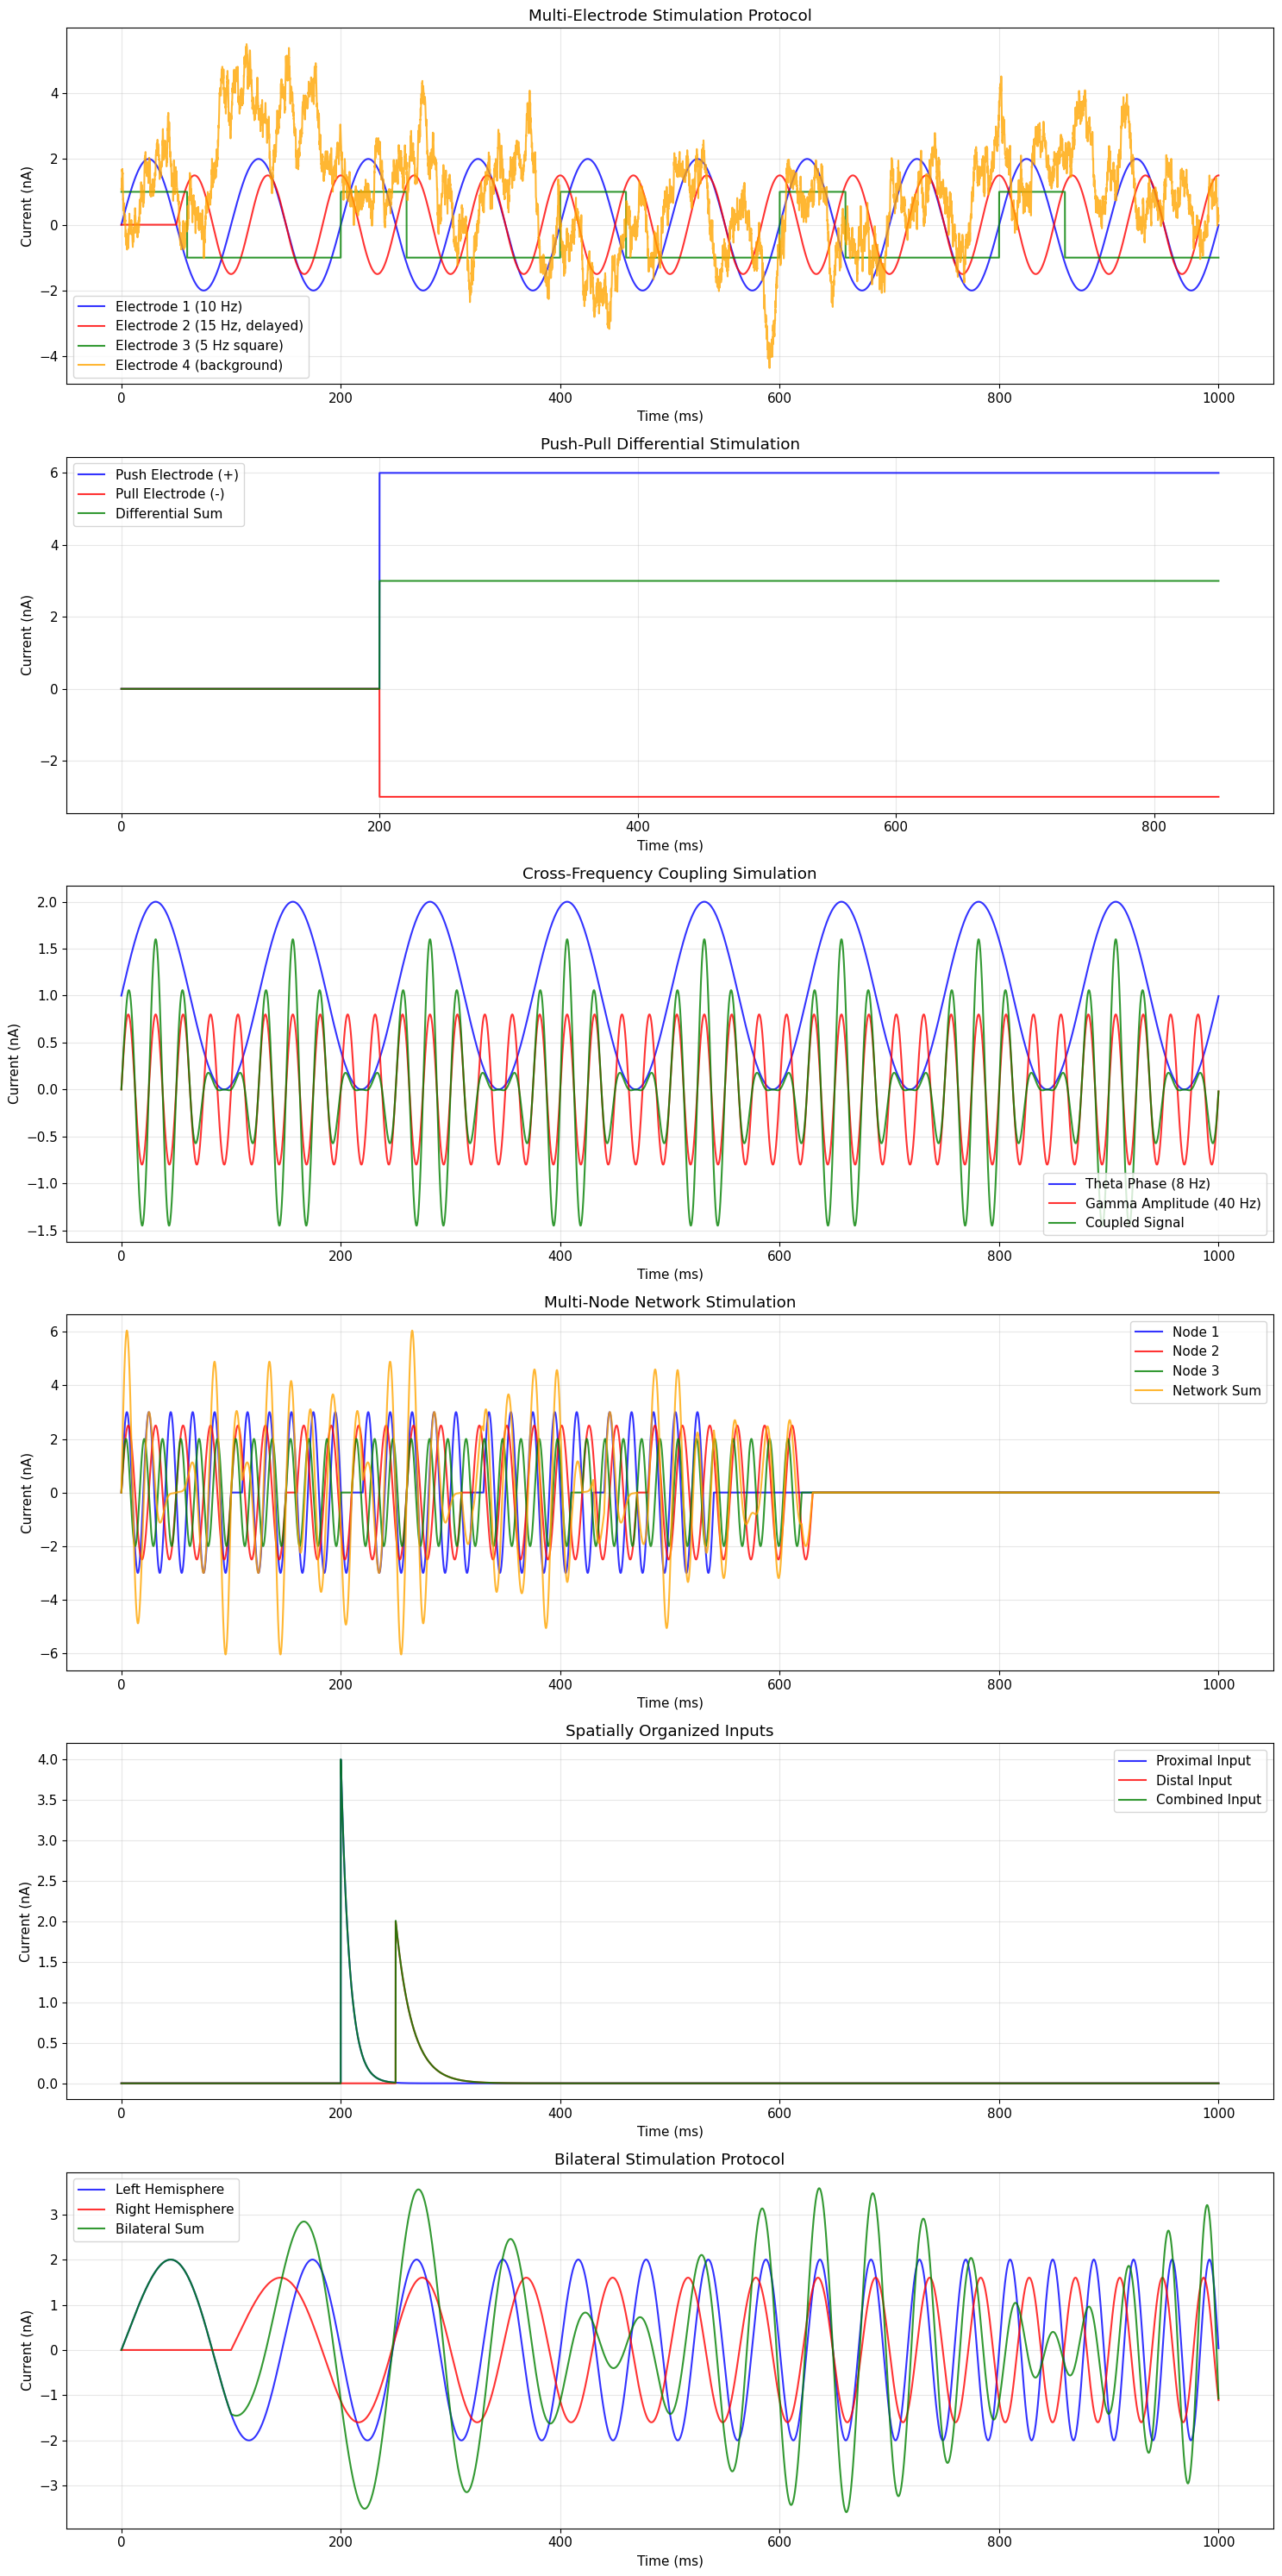

Parallel combination features:
- Multiple independent channels with different properties
- Time delays with .shift() method
- Amplitude scaling with .scale() method
- Combination with arithmetic operations (+, -, *, /)
- Useful for: multi-electrode arrays, bilateral stimulation, network protocols


In [51]:
with brainstate.environ.context(dt=dt):
    duration = 1000 * u.ms

    # Multi-electrode stimulation protocol
    electrode1 = braintools.input.Sinusoidal(2.0, 10 * u.Hz, duration)  # Primary stimulation
    electrode2 = braintools.input.Sinusoidal(1.5, 15 * u.Hz, duration).shift(50 * u.ms)  # Delayed stimulation
    electrode3 = braintools.input.Square(1.0, 5 * u.Hz, duration, duty_cycle=0.3)  # Gating signal
    electrode4 = braintools.input.OUProcess(mean=1.0, sigma=0.5, tau=20 * u.ms, duration=duration,
                                            seed=42)  # Background

    # Differential stimulation (push-pull)
    push_electrode = braintools.input.Step([0, 4, 0, 6, 0], [150, 200, 150, 200, 150] * u.ms, 850 * u.ms)
    pull_electrode = push_electrode.scale(-0.5)  # Opposite polarity, half amplitude

    # Cross-frequency coupling simulation
    theta_generator = braintools.input.Sinusoidal(1.0, 8 * u.Hz, duration, bias=True)  # Theta phase
    gamma_bursts = braintools.input.Sinusoidal(0.8, 40 * u.Hz, duration)  # Gamma amplitude
    coupled_signal = gamma_bursts * theta_generator  # Phase-amplitude coupling

    # Network-like stimulation with delays
    node1 = braintools.input.Burst(burst_duration=100 * u.ms, duration=duration, n_bursts=5, burst_freq=50 * u.Hz,
                                   burst_amp=3.0, inter_burst_interval=10 * u.ms)
    node2 = braintools.input.Burst(burst_duration=150 * u.ms, duration=duration, n_bursts=4, burst_freq=40 * u.Hz,
                                   burst_amp=2.5, inter_burst_interval=10 * u.ms)  # Different timing
    node3 = braintools.input.Burst(burst_duration=200 * u.ms, duration=duration, n_bursts=3, burst_freq=60 * u.Hz,
                                   burst_amp=2.0, inter_burst_interval=10 * u.ms)  # Different parameters

    # Composite network signal
    network_sum = node1 + node2.scale(0.8) + node3.scale(0.6)

    # Spatially organized stimulation
    proximal_input = braintools.input.ExponentialDecay(t_start=200 * u.ms, duration=duration, tau=8 * u.ms,
                                                       amplitude=4.0)
    distal_input = braintools.input.ExponentialDecay(t_start=250 * u.ms, duration=duration, tau=15 * u.ms,
                                                     amplitude=2.0)  # Slower kinetics

    # Bilateral stimulation
    left_hemisphere = braintools.input.Chirp(2.0, 5 * u.Hz, 30 * u.Hz, duration)
    right_hemisphere = left_hemisphere.shift(100 * u.ms).scale(0.8)  # Delayed and attenuated

# Generate parallel signals
parallel_examples = [
    {
        'signals': [
            (electrode1(), 'Electrode 1 (10 Hz)'),
            (electrode2(), 'Electrode 2 (15 Hz, delayed)'),
            (electrode3(), 'Electrode 3 (5 Hz square)'),
            (electrode4(), 'Electrode 4 (background)')
        ],
        'title': 'Multi-Electrode Stimulation Protocol'
    },
    {
        'signals': [
            (push_electrode(), 'Push Electrode (+)'),
            (pull_electrode(), 'Pull Electrode (-)'),
            ((push_electrode + pull_electrode)(), 'Differential Sum')
        ],
        'title': 'Push-Pull Differential Stimulation'
    },
    {
        'signals': [
            (theta_generator(), 'Theta Phase (8 Hz)'),
            (gamma_bursts(), 'Gamma Amplitude (40 Hz)'),
            (coupled_signal(), 'Coupled Signal')
        ],
        'title': 'Cross-Frequency Coupling Simulation'
    },
    {
        'signals': [
            (node1(), 'Node 1'),
            (node2(), 'Node 2'),
            (node3(), 'Node 3'),
            (network_sum(), 'Network Sum')
        ],
        'title': 'Multi-Node Network Stimulation'
    },
    {
        'signals': [
            (proximal_input(), 'Proximal Input'),
            (distal_input(), 'Distal Input'),
            ((proximal_input + distal_input)(), 'Combined Input')
        ],
        'title': 'Spatially Organized Inputs'
    },
    {
        'signals': [
            (left_hemisphere(), 'Left Hemisphere'),
            (right_hemisphere(), 'Right Hemisphere'),
            ((left_hemisphere + right_hemisphere)(), 'Bilateral Sum')
        ],
        'title': 'Bilateral Stimulation Protocol'
    }
]

# Plot parallel examples
fig, axes = plt.subplots(6, 1, figsize=(15, 30))

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, example in enumerate(parallel_examples):
    ax = axes[i]
    for j, (signal, label) in enumerate(example['signals']):
        color = colors[j % len(colors)]
        duration_to_plot = 1000 * u.ms if 'Network' in example['title'] else duration
        if 'Push-Pull' in example['title']:
            duration_to_plot = 850 * u.ms

        plot_signal(signal, duration_to_plot, example['title'], ax,
                    color=color, label=label, alpha=0.8)
    ax.legend()

plt.tight_layout()
plt.show()

print("Parallel combination features:")
print("- Multiple independent channels with different properties")
print("- Time delays with .shift() method")
print("- Amplitude scaling with .scale() method")
print("- Combination with arithmetic operations (+, -, *, /)")
print("- Useful for: multi-electrode arrays, bilateral stimulation, network protocols")

## 5. Advanced Composable Techniques

Professional-level techniques for complex experimental protocols.

### 5.1 Dynamic Protocol Building

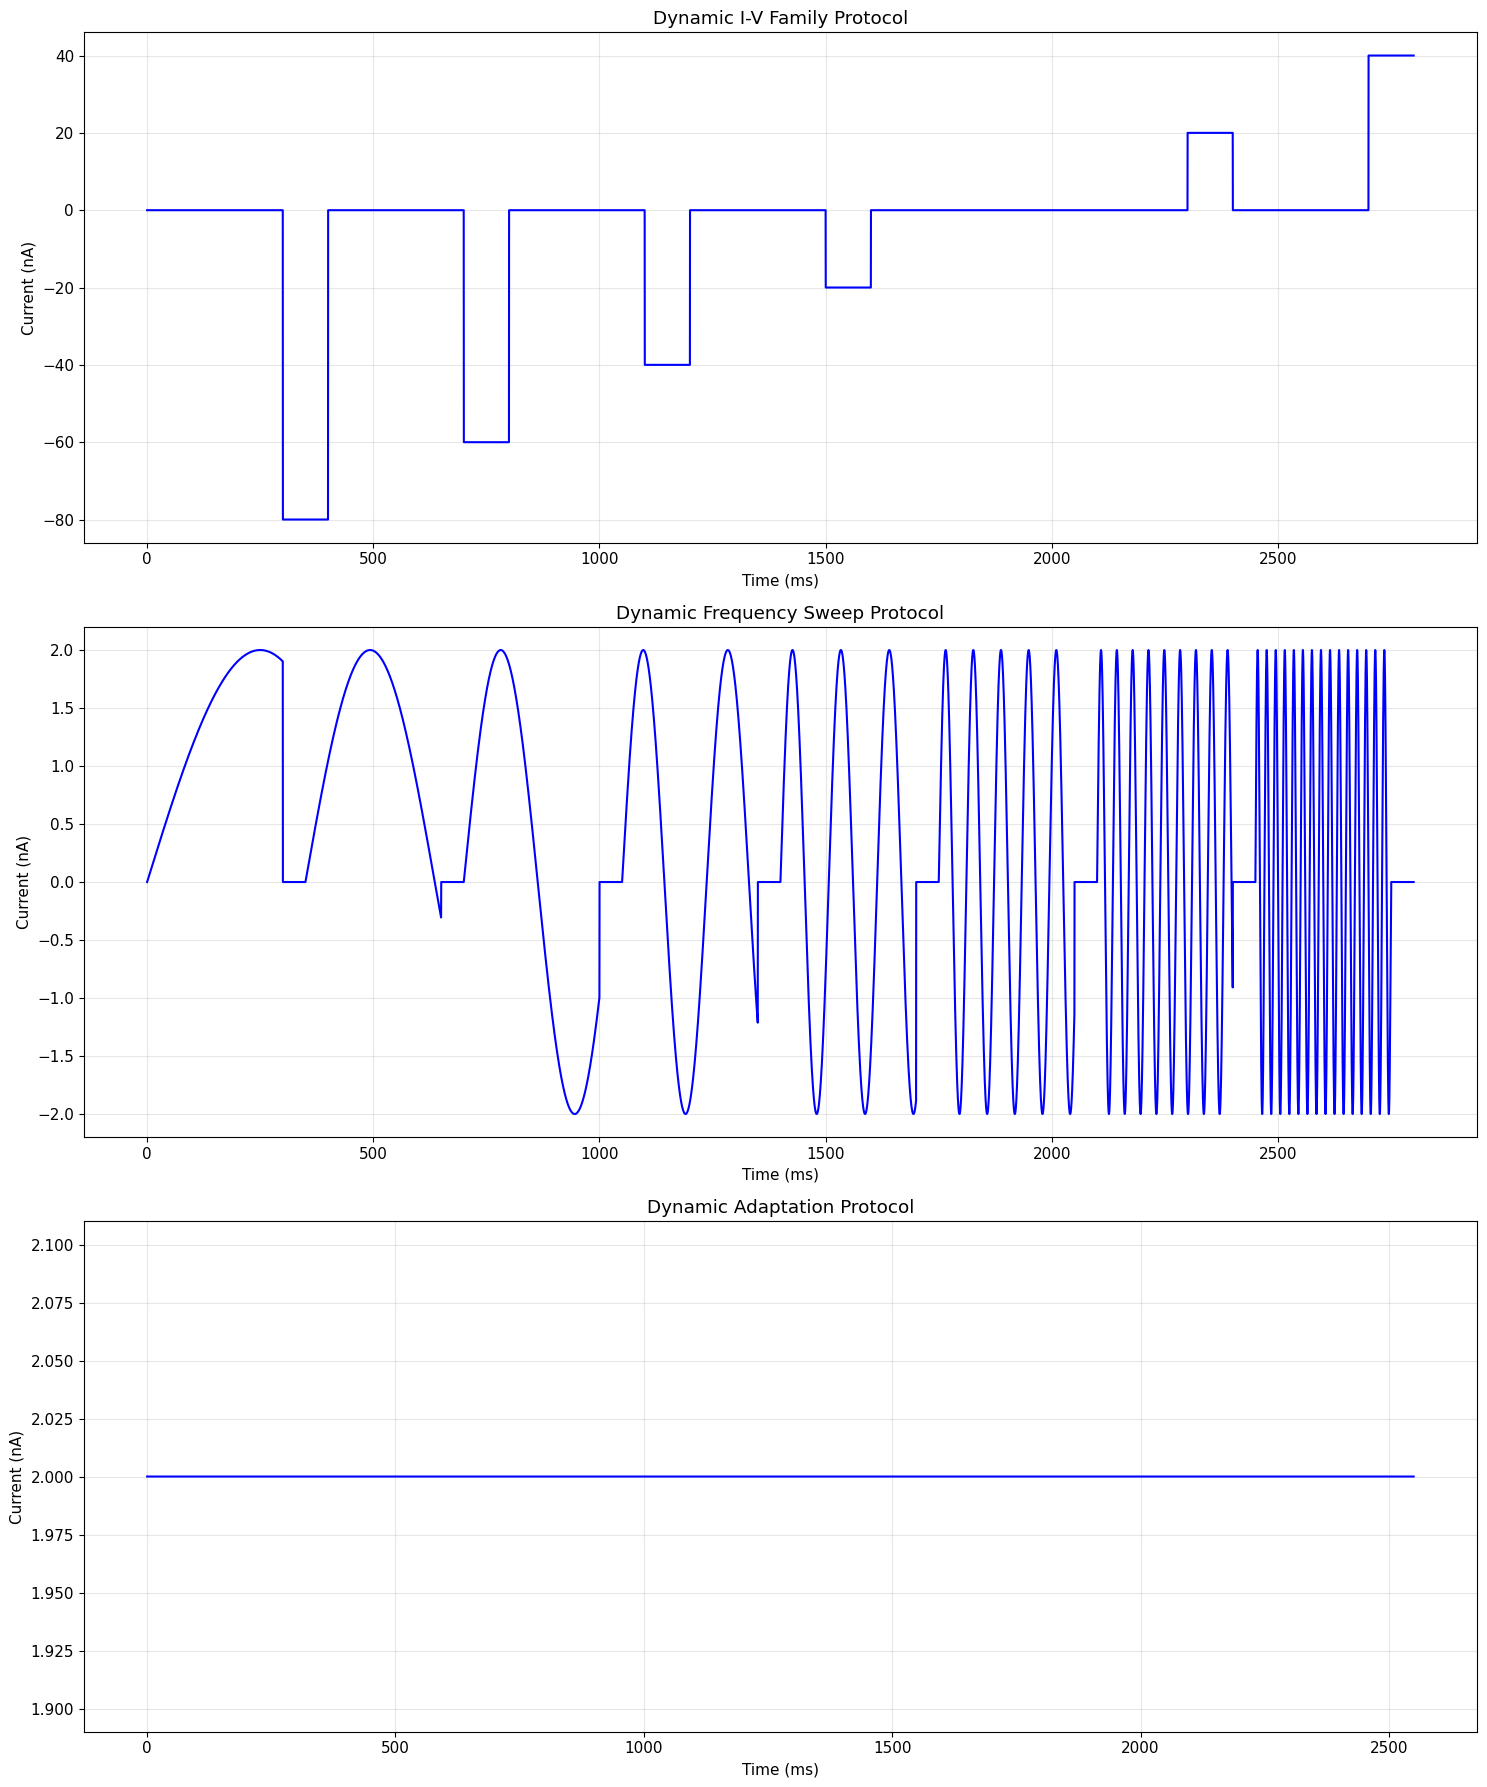

Dynamic protocol features:
- Programmatic generation based on parameters
- Reusable functions for common experimental patterns
- Easy to modify parameters without rebuilding protocol
- Can generate families of related protocols
- I-V protocol: 2800 ms
- Frequency sweep: 2800 ms
- Adaptation test: 2550 ms


In [53]:
# Dynamic protocol generation based on parameters
def create_iv_family(v_start, v_end, n_steps, step_duration, inter_step_duration):
    """Create a voltage clamp family protocol."""
    voltages = np.linspace(v_start, v_end, n_steps)

    protocol_parts = [braintools.input.Constant([(0, 100 * u.ms)])]  # Initial baseline

    for v in voltages:
        # Add voltage step
        protocol_parts.append(
            braintools.input.Step(
                [0, v, 0],
                [50 * u.ms, step_duration, 50 * u.ms],
                step_duration + 100 * u.ms
            )
        )
        # Add inter-step interval
        if v != voltages[-1]:  # No interval after last step
            protocol_parts.append(
                braintools.input.Constant([(0, inter_step_duration)])
            )

    return braintools.input.Sequential(*protocol_parts)


def create_frequency_sweep(f_start, f_end, n_freqs, amplitude, duration_per_freq):
    """Create a frequency sweep protocol."""
    frequencies = np.logspace(np.log10(f_start), np.log10(f_end), n_freqs)

    sweep_parts = []
    for freq in frequencies:
        sine_component = braintools.input.Sinusoidal(amplitude, freq * u.Hz, duration_per_freq)
        sweep_parts.append(sine_component)
        # Add brief pause between frequencies
        sweep_parts.append(braintools.input.Constant([(0, 50 * u.ms)]))

    return braintools.input.Sequential(*sweep_parts)


def create_adaptation_protocol(
    base_current,
    n_pulses,
    pulse_amplitude,
    pulse_duration,
    inter_pulse_interval
):
    """Create an adaptation testing protocol."""
    protocol_parts = [braintools.input.Constant([(base_current, 500 * u.ms)])]  # Baseline

    for i in range(n_pulses):
        # Add depolarizing pulse
        pulse = braintools.input.Step([base_current, base_current + pulse_amplitude, base_current],
                                      [0 * u.ms, pulse_duration, 0 * u.ms],
                                      pulse_duration)
        protocol_parts.append(pulse)

        # Add inter-pulse interval (except after last pulse)
        if i < n_pulses - 1:
            protocol_parts.append(braintools.input.Constant([(base_current, inter_pulse_interval)]))

    # Final recovery period
    protocol_parts.append(braintools.input.Constant([(base_current, 1000 * u.ms)]))

    return braintools.input.Sequential(*protocol_parts)


# Generate dynamic protocols
with brainstate.environ.context(dt=dt):
    # I-V family: -80 to +40 mV in 7 steps
    iv_protocol = create_iv_family(-80, 40, 7, 200 * u.ms, 100 * u.ms)

    # Frequency sweep: 1 to 50 Hz in 8 frequencies
    freq_protocol = create_frequency_sweep(1, 50, 8, 2.0, 300 * u.ms)

    # Adaptation protocol: 5 pulses
    adapt_protocol = create_adaptation_protocol(2.0, 5, 8.0, 50 * u.ms, 200 * u.ms)

# Calculate durations
iv_duration = (100 + 7 * (200 + 100) + 6 * 100) * u.ms  # Baseline + steps + intervals
freq_duration = (8 * (300 + 50)) * u.ms  # 8 frequencies + pauses
adapt_duration = (500 + 5 * 50 + 4 * 200 + 1000) * u.ms  # All components

# Plot dynamic protocols
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

plot_signal(iv_protocol(), iv_duration, 'Dynamic I-V Family Protocol', axes[0])
plot_signal(freq_protocol(), freq_duration, 'Dynamic Frequency Sweep Protocol', axes[1])
plot_signal(adapt_protocol(), adapt_duration, 'Dynamic Adaptation Protocol', axes[2])

plt.tight_layout()
plt.show()

print("Dynamic protocol features:")
print("- Programmatic generation based on parameters")
print("- Reusable functions for common experimental patterns")
print("- Easy to modify parameters without rebuilding protocol")
print("- Can generate families of related protocols")
print(f"- I-V protocol: {u.get_magnitude(iv_duration):.0f} ms")
print(f"- Frequency sweep: {u.get_magnitude(freq_duration):.0f} ms")
print(f"- Adaptation test: {u.get_magnitude(adapt_duration):.0f} ms")

### 5.2 Protocol Templates and Reusability

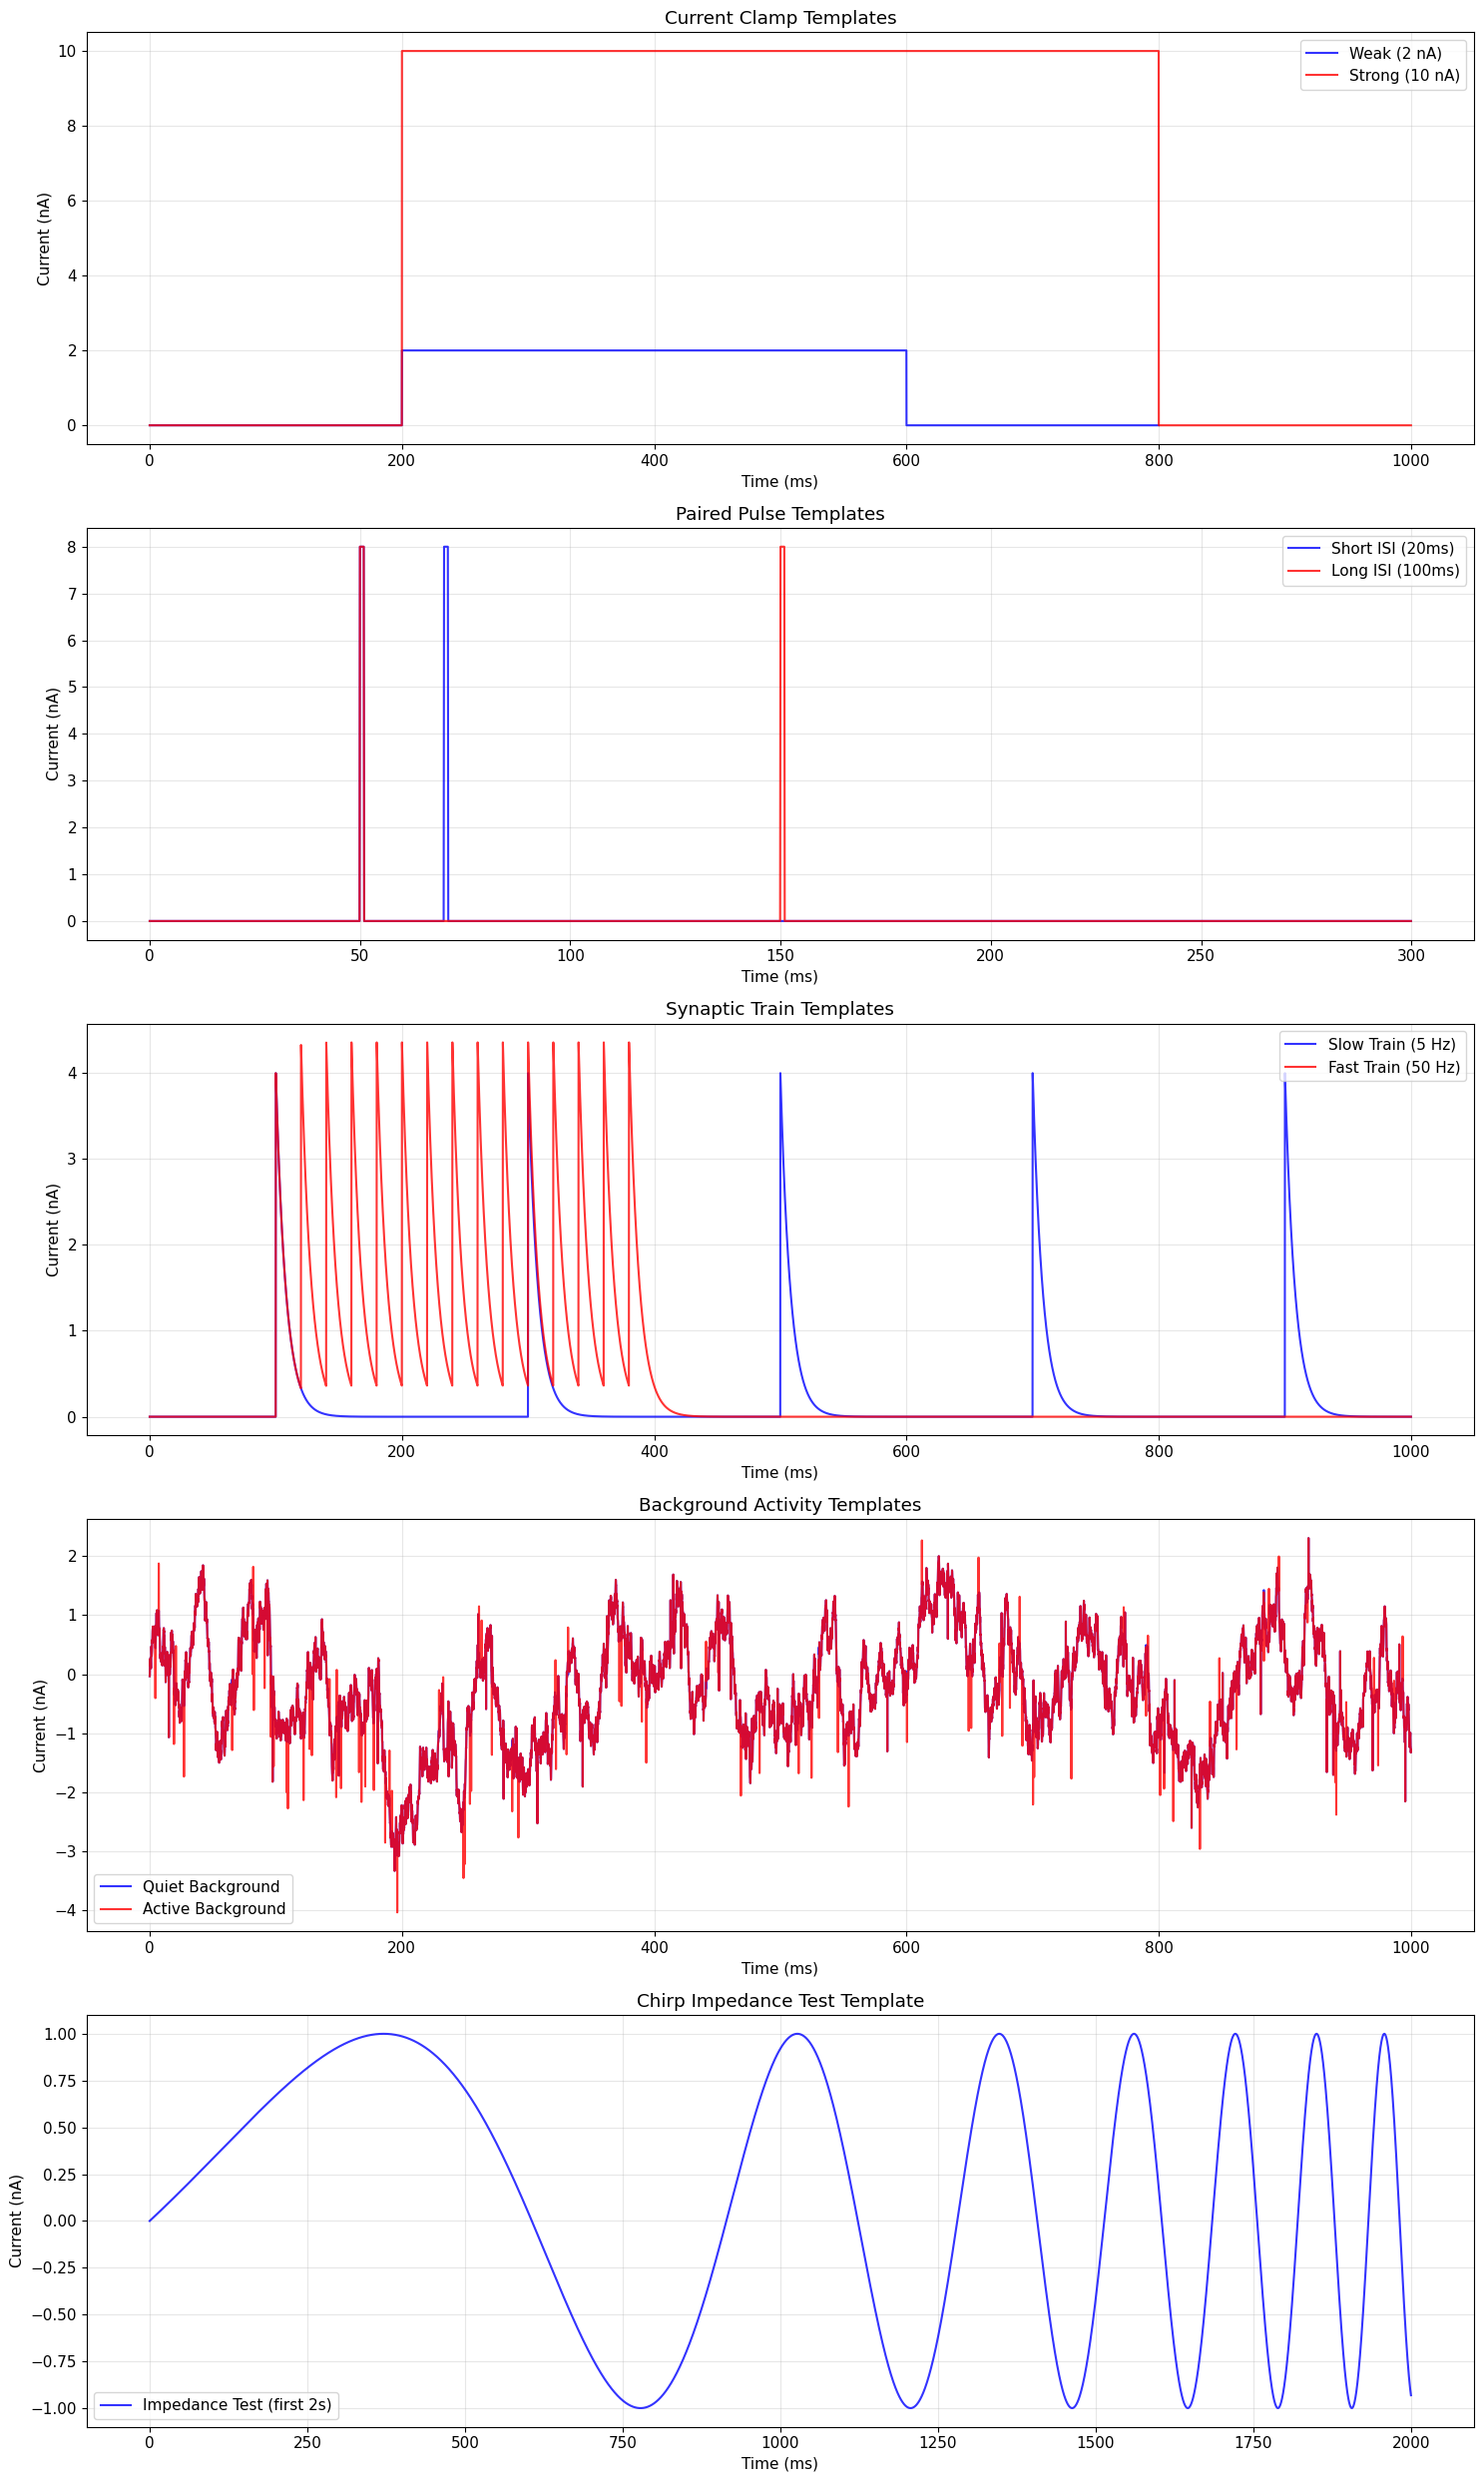

Protocol template features:
- Encapsulate common experimental patterns
- Parameterized for easy customization
- Promote code reuse and consistency
- Easy to share and standardize protocols
- Can be combined to create complex experiments


In [54]:
# Create reusable protocol templates
class ProtocolTemplates:
    """Collection of reusable electrophysiology protocol templates."""

    @staticmethod
    def current_clamp_basic(
        baseline_duration=200 * u.ms,
        test_current=5.0,
        test_duration=400 * u.ms,
        recovery_duration=200 * u.ms
    ):
        """Basic current clamp protocol."""
        return braintools.input.Section(
            [0, test_current, 0],
            [baseline_duration, test_duration, recovery_duration]
        )

    @staticmethod
    def paired_pulse(
        pulse_width=5 * u.ms,
        inter_pulse_interval=50 * u.ms,
        total_duration=300 * u.ms
    ):
        """Paired pulse protocol for short-term plasticity."""
        pulse1 = braintools.input.Spike([50 * u.ms], total_duration, sp_lens=1.0 * u.ms, sp_sizes=8.0)
        pulse2 = braintools.input.Spike([50 * u.ms + inter_pulse_interval], total_duration, sp_lens=1.0 * u.ms,
                                        sp_sizes=8.0)
        return pulse1 + pulse2

    @staticmethod
    def synaptic_train(
        frequency=20 * u.Hz,
        n_pulses=10,
        tau_decay=8 * u.ms,
        total_duration=1000 * u.ms
    ):
        """Train of synaptic-like inputs."""
        isi = 1000 / u.get_magnitude(frequency)  # Inter-spike interval in ms

        train_inputs = []
        for i in range(n_pulses):
            spike_time = 100 + i * isi  # Start at 100ms
            if spike_time * u.ms < total_duration:
                epsc = braintools.input.ExponentialDecay(
                    t_start=spike_time * u.ms, duration=total_duration, tau=tau_decay, amplitude=4.0
                )
                train_inputs.append(epsc)

        # Sum all EPSCs
        result = train_inputs[0]
        for epsc in train_inputs[1:]:
            result = result + epsc
        return result

    @staticmethod
    def realistic_background(
        exc_rate=30 * u.Hz,
        inh_rate=40 * u.Hz,
        exc_amplitude=0.8,
        inh_amplitude=-1.2,
        duration=2000 * u.ms,
        seed=42
    ):
        """Realistic background synaptic activity."""
        # Excitatory Poisson input
        exc_input = braintools.input.Poisson(rate=exc_rate, duration=duration, amplitude=exc_amplitude, seed=seed)

        # Inhibitory Poisson input
        inh_input = braintools.input.Poisson(rate=inh_rate, duration=duration, amplitude=inh_amplitude, seed=seed + 100)

        # Correlated background fluctuations
        background_ou = braintools.input.OUProcess(mean=0., sigma=0.3, tau=20 * u.ms, duration=duration, seed=seed + 200)

        return exc_input + inh_input + background_ou

    @staticmethod
    def chirp_impedance_test(
        amplitude=1.0,
        f_start=0.5 * u.Hz,
        f_end=50 * u.Hz,
        duration=10000 * u.ms,
        method='logarithmic'
    ):
        """Chirp signal for impedance/resonance testing."""
        return braintools.input.Chirp(amplitude, f_start, f_end, duration, method=method)


# Demonstrate template usage
with brainstate.environ.context(dt=dt):
    # Use templates with different parameters
    templates = ProtocolTemplates()

    # Basic current clamp variations
    cc_weak = templates.current_clamp_basic(test_current=2.0)
    cc_strong = templates.current_clamp_basic(test_current=10.0, test_duration=600 * u.ms)

    # Paired pulse with different intervals
    pp_short = templates.paired_pulse(inter_pulse_interval=20 * u.ms)
    pp_long = templates.paired_pulse(inter_pulse_interval=100 * u.ms)

    # Synaptic trains
    train_slow = templates.synaptic_train(frequency=5 * u.Hz, n_pulses=8)
    train_fast = templates.synaptic_train(frequency=50 * u.Hz, n_pulses=15)

    # Background activity
    bg_quiet = templates.realistic_background(exc_rate=15 * u.Hz, inh_rate=20 * u.Hz)
    bg_active = templates.realistic_background(exc_rate=60 * u.Hz, inh_rate=80 * u.Hz)

    # Impedance test
    impedance_test = templates.chirp_impedance_test(duration=3000 * u.ms)

# Plot template examples
template_examples = [
    {
        'signals': [(cc_weak(), 'Weak (2 nA)'), (cc_strong(), 'Strong (10 nA)')],
        'duration': [800 * u.ms, 1000 * u.ms],
        'title': 'Current Clamp Templates'
    },
    {
        'signals': [(pp_short(), 'Short ISI (20ms)'), (pp_long(), 'Long ISI (100ms)')],
        'duration': [300 * u.ms, 300 * u.ms],
        'title': 'Paired Pulse Templates'
    },
    {
        'signals': [(train_slow(), 'Slow Train (5 Hz)'), (train_fast(), 'Fast Train (50 Hz)')],
        'duration': [1000 * u.ms, 1000 * u.ms],
        'title': 'Synaptic Train Templates'
    },
    {
        'signals': [(bg_quiet()[:10000], 'Quiet Background'), (bg_active()[:10000], 'Active Background')],
        'duration': [1000 * u.ms, 1000 * u.ms],
        'title': 'Background Activity Templates'
    },
    {
        'signals': [(impedance_test()[:20000], 'Impedance Test (first 2s)')],
        'duration': [2000 * u.ms],
        'title': 'Chirp Impedance Test Template'
    }
]

fig, axes = plt.subplots(5, 1, figsize=(15, 25))
colors = ['blue', 'red', 'green']

for i, example in enumerate(template_examples):
    ax = axes[i]
    for j, (signal, label) in enumerate(example['signals']):
        duration = example['duration'][j] if len(example['duration']) > 1 else example['duration'][0]
        plot_signal(signal, duration, example['title'], ax,
                    color=colors[j], label=label, alpha=0.8)
    ax.legend()

plt.tight_layout()
plt.show()

print("Protocol template features:")
print("- Encapsulate common experimental patterns")
print("- Parameterized for easy customization")
print("- Promote code reuse and consistency")
print("- Easy to share and standardize protocols")
print("- Can be combined to create complex experiments")